# Processing results using BigQuery #

We start by importing all the requisite packages from BayesCMD etc. as well as ones required to plot and read data from big query.

In [1]:
import os
import argparse
from pathlib import Path
import json
import matplotlib.pyplot as plt
from distutils import dir_util
from pprint import pprint
import pickle

# BayesCMD packages 
from bayescmd.results_handling import kde_plot
from bayescmd.results_handling import scatter_dist_plot
from bayescmd.results_handling import data_import
from bayescmd.results_handling import plot_repeated_outputs
from bayescmd.results_handling import histogram_plot
from bayescmd.results_handling import data_merge_by_batch
from bayescmd.abc import import_actual_data
from bayescmd.abc import priors_creator

# Google BigQuery
from google.cloud import bigquery
%load_ext google.cloud.bigquery

STARTING AT: /home/buck06191/repos/Github/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/Github/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/Github/BayesCMD/bayescmd
 Looking for: BayesCMD


In [2]:
# Explicitly use service account credentials by specifying the private
# key file. All clients in google-cloud-python have this helper.
client = bigquery.Client.from_service_account_json(
    "../../gcloud/hypothermia-auth.json"
)

In [3]:
def generate_histogram_query(project, dataset, model, n_bins, distance):
    histogram_query = """
    SELECT
      MIN(data.{distance}) AS min,
      MAX(data.{distance}) AS max,
      COUNT(data.{distance}) AS num,
      INTEGER((data.{distance}-value.min)/(value.max-value.min)*{n_bins}) AS group_
    FROM
      [{project}:{dataset}.{model}] data
    CROSS JOIN (
      SELECT
        MAX({distance}) AS max,
        MIN({distance}) AS min
      FROM
        [{project}:{dataset}.{model}]) value
    GROUP BY
      group_
    ORDER BY
      group_
    """.format(dataset=dataset, model=model, n_bins=n_bins, distance=distance, project=project)
    return histogram_query

In [4]:
def generate_posterior_query(project, dataset, model, distance, parameters, limit=50000):
    unpacked_params = ",\n".join(parameters)
    histogram_query = """
SELECT
    {unpacked_params},
    {distance},
    idx
FROM
  `{project}.{dataset}.{model}`
ORDER BY
  {distance} ASC
LIMIT
  {limit}
    """.format(project=project, dataset=dataset, model=model, unpacked_params=unpacked_params,distance=distance, limit=limit)
    return histogram_query

In [5]:
def load_configuration(model_version, dataset, verbose=False):
    current_file = Path(os.path.abspath(''))
    config_file = os.path.join(current_file.parents[2],
                              'config_files',
                               'abc',
                               'bp_hypothermia_{}'.format(model_version),
                               'bp_hypothermia_{}_config.json'.format(model_version)
                              )

    with open(config_file, 'r') as conf_f:
        conf = json.load(conf_f)

    params = conf['priors']

    input_path = os.path.join(current_file.parents[2],
                              'data',
                              'clean_hypothermia',
                              '{}_filtered_formatted.csv'.format(dataset.upper()))

    d0 = import_actual_data(input_path)

    targets = conf['targets']
    model_name = conf['model_name']
    inputs = conf['inputs']

    config = {
        "model_name": model_name,
        "targets": targets,
        "inputs": inputs,
        "parameters": params,
        "input_path": input_path,
        "zero_flag": conf['zero_flag'],
    }
    
    if verbose:
        pprint(config)
        
    return config, d0

In [6]:
configuration = {}
combinations = [('2', 'LWP475'), ('2_1', 'LWP479')]

for combo in combinations:
    
    model_number = combo[0]
    DATASET = combo[1]

    model_name = 'bph{}'.format(model_number)
    configuration[model_name] = {}

    configuration[model_name][DATASET] = {}
    config, d0 = load_configuration(model_number, DATASET)
    configuration[model_name][DATASET]['bayescmd_config'] = config
    configuration[model_name][DATASET]['original_data']= d0

    configuration[model_name][DATASET]['histogram_query'] = generate_histogram_query('hypothermia-bayescmd', 
                                                                                        DATASET, 
                                                                                        model_name, 
                                                                                        100, 
                                                                                        'NRMSE')

    configuration[model_name][DATASET]['posterior_query'] = generate_posterior_query('hypothermia-bayescmd', 
                                                                                        DATASET, 
                                                                                        model_name, 
                                                                                        'NRMSE', 
                                                                                        list(configuration[model_name][DATASET]['bayescmd_config']['parameters'].keys()))


In [7]:
configuration['bph2'].keys()

dict_keys(['LWP475'])

Working on bph2 - LWP475
	Running SQL query
	Plotting posterior
	Plotting Posterior Predictive
Sample 0, idx:39470
{'K_sigma': 11.506705700974061,
 'NADpool': 3.5838813201132287,
 'Q_10_haemo': 4.951089132451552,
 'Q_10_met': 5.042142914746709,
 'Xtot_n': 5.363584892266854,
 '_L0n': 3.417979591565415,
 'a_frac_n': 0.19631639963449146,
 'pH_mn': 7.258814334858315,
 'phi': 0.031118623543671495,
 'r_0': 0.013909033327049878,
 'r_n': 0.01991144348000185}
Sample 1, idx:37854
{'K_sigma': 9.650538091738207,
 'NADpool': 3.6163972491021634,
 'Q_10_haemo': 3.819549491248044,
 'Q_10_met': 5.732900645827413,
 'Xtot_n': 4.109562497477048,
 '_L0n': 0.2048940564496277,
 'a_frac_n': 0.3611545378252761,
 'pH_mn': 7.427972437007817,
 'phi': 0.04195308526413508,
 'r_0': 0.010379622847339755,
 'r_n': 0.015211882797060478}
Sample 2, idx:26648
{'K_sigma': 8.176183884553849,
 'NADpool': 4.411464564498427,
 'Q_10_haemo': 5.232421852934358,
 'Q_10_met': 4.946056398515497,
 'Xtot_n': 4.46674925602708,
 '_L0n': 

Sample 23, idx:25075
{'K_sigma': 10.240039242174452,
 'NADpool': 3.237706363782374,
 'Q_10_haemo': 3.4573997959031946,
 'Q_10_met': 5.305529270649608,
 'Xtot_n': 4.477444465669689,
 '_L0n': 3.9390763681427248,
 'a_frac_n': 0.2814827899571747,
 'pH_mn': 7.5573064981563345,
 'phi': 0.03964184079103851,
 'r_0': 0.012570570879278313,
 'r_n': 0.018130902773006632}
Sample 24, idx:47630
{'K_sigma': 9.856683297269146,
 'NADpool': 4.007364225620046,
 'Q_10_haemo': 4.982635967407508,
 'Q_10_met': 5.746982791410304,
 'Xtot_n': 4.464860940436235,
 '_L0n': 4.3976457763228485,
 'a_frac_n': 0.2408585370707053,
 'pH_mn': 7.2704656183366625,
 'phi': 0.031525779538552186,
 'r_0': 0.012379592665343057,
 'r_n': 0.017688983711725812}
Sample 25, idx:35372
{'K_sigma': 10.182900832054257,
 'NADpool': 3.0454257466851384,
 'Q_10_haemo': 1.956228802077404,
 'Q_10_met': 5.482964194408673,
 'Xtot_n': 4.005920923027305,
 '_L0n': 2.8493161077295883,
 'a_frac_n': 0.2296532465178361,
 'pH_mn': 7.375937370611173,
 'phi

Sample 46, idx:20123
{'K_sigma': 11.176136697831991,
 'NADpool': 3.6955302912624317,
 'Q_10_haemo': 4.297128647973417,
 'Q_10_met': 5.9211080189602425,
 'Xtot_n': 5.572240626583572,
 '_L0n': 2.4952442470147833,
 'a_frac_n': 0.2707245603211059,
 'pH_mn': 7.577589687289526,
 'phi': 0.041262100442954905,
 'r_0': 0.014467585770000962,
 'r_n': 0.020791855698729038}
Sample 47, idx:25604
{'K_sigma': 11.076296809516304,
 'NADpool': 3.3902763838589736,
 'Q_10_haemo': 5.360766201923411,
 'Q_10_met': 4.791560444840657,
 'Xtot_n': 4.2663544063388965,
 '_L0n': 3.707920543322234,
 'a_frac_n': 0.2195738919422537,
 'pH_mn': 7.326167456747223,
 'phi': 0.038060403789643434,
 'r_0': 0.012232168347441338,
 'r_n': 0.01785943208049902}
Sample 48, idx:48836
{'K_sigma': 10.552374681435687,
 'NADpool': 3.1869293897223283,
 'Q_10_haemo': 4.717547392357832,
 'Q_10_met': 5.466057094723791,
 'Xtot_n': 4.586850168931244,
 '_L0n': 4.03780736394725,
 'a_frac_n': 0.16278510178251349,
 'pH_mn': 7.3961594517992975,
 'ph

Sample 69, idx:42671
{'K_sigma': 11.761425260667883,
 'NADpool': 3.8105317699189714,
 'Q_10_haemo': 2.0678578838591,
 'Q_10_met': 5.42147458251838,
 'Xtot_n': 5.375789607531856,
 '_L0n': 2.1644297246760025,
 'a_frac_n': 0.20151010015954893,
 'pH_mn': 7.298699323348456,
 'phi': 0.036558504705137086,
 'r_0': 0.011526717800266977,
 'r_n': 0.01585584495738291}
Sample 70, idx:31618
{'K_sigma': 10.309272374581981,
 'NADpool': 2.712815335840405,
 'Q_10_haemo': 1.5179857479293817,
 'Q_10_met': 5.520890163575479,
 'Xtot_n': 4.710188846358705,
 '_L0n': 1.531573796184826,
 'a_frac_n': 0.34366789638365736,
 'pH_mn': 7.369914007571403,
 'phi': 0.031888231863405656,
 'r_0': 0.011014746657222805,
 'r_n': 0.01535832907771062}
Sample 71, idx:26464
{'K_sigma': 10.767965077858033,
 'NADpool': 3.5824222881954406,
 'Q_10_haemo': 1.244238915779541,
 'Q_10_met': 5.180257340147488,
 'Xtot_n': 3.8308951710735615,
 '_L0n': 4.948401401631236,
 'a_frac_n': 0.14343698951243555,
 'pH_mn': 7.448269443961843,
 'phi':

Sample 92, idx:15026
{'K_sigma': 10.236559364015749,
 'NADpool': 3.079520953459118,
 'Q_10_haemo': 3.582852455838509,
 'Q_10_met': 4.876749334256086,
 'Xtot_n': 4.2081622514700605,
 '_L0n': 3.060256850193507,
 'a_frac_n': 0.21824703004132973,
 'pH_mn': 7.268794156990058,
 'phi': 0.03897891993849673,
 'r_0': 0.010713728992392363,
 'r_n': 0.015052948755581616}
Sample 93, idx:15074
{'K_sigma': 10.191533689706175,
 'NADpool': 3.712052725866319,
 'Q_10_haemo': 5.658718463058567,
 'Q_10_met': 5.6304048174599,
 'Xtot_n': 5.588308810003403,
 '_L0n': 1.4381585983688323,
 'a_frac_n': 0.2468376489773664,
 'pH_mn': 7.566532983393817,
 'phi': 0.04171863036954547,
 'r_0': 0.011418902322649686,
 'r_n': 0.016835096626950496}
Sample 94, idx:12897
{'K_sigma': 11.98232317182808,
 'NADpool': 4.081297388902003,
 'Q_10_haemo': 4.7574154917006855,
 'Q_10_met': 5.794044839440278,
 'Xtot_n': 4.303678820657909,
 '_L0n': 3.1929121934940534,
 'a_frac_n': 0.1910848218956056,
 'pH_mn': 7.326238254039202,
 'phi': 0.

Sample 115, idx:11579
{'K_sigma': 11.539282467452665,
 'NADpool': 2.8609253988485586,
 'Q_10_haemo': 3.530589553317787,
 'Q_10_met': 5.601995451931955,
 'Xtot_n': 5.181410632187283,
 '_L0n': 4.587477754674854,
 'a_frac_n': 0.23336082680691486,
 'pH_mn': 7.474008475988245,
 'phi': 0.037508591489603185,
 'r_0': 0.012149528508278155,
 'r_n': 0.017300433468447233}
Sample 116, idx:9218
{'K_sigma': 8.55145899967165,
 'NADpool': 2.7997287731287206,
 'Q_10_haemo': 4.236358615472716,
 'Q_10_met': 5.492108461757669,
 'Xtot_n': 3.668525651146052,
 '_L0n': 1.9218774139849124,
 'a_frac_n': 0.32466083806208423,
 'pH_mn': 7.464933557983028,
 'phi': 0.033155056874776725,
 'r_0': 0.010380950697663791,
 'r_n': 0.015365675683998528}
Sample 117, idx:18413
{'K_sigma': 8.628624349984477,
 'NADpool': 3.1185388955160422,
 'Q_10_haemo': 2.2741435098889484,
 'Q_10_met': 5.188881927004541,
 'Xtot_n': 4.5543616662987105,
 '_L0n': 4.093944082304973,
 'a_frac_n': 0.18933253745936707,
 'pH_mn': 7.322346094025602,
 '

Sample 138, idx:10639
{'K_sigma': 10.73433598116162,
 'NADpool': 3.180562374084259,
 'Q_10_haemo': 5.218639155352388,
 'Q_10_met': 5.747630051554992,
 'Xtot_n': 4.922653281949847,
 '_L0n': 3.0553267138988547,
 'a_frac_n': 0.2863722999486425,
 'pH_mn': 7.256644030009787,
 'phi': 0.036671875414158416,
 'r_0': 0.01382567723374169,
 'r_n': 0.01998622424124812}
Sample 139, idx:23052
{'K_sigma': 9.691630161741179,
 'NADpool': 3.315971422843893,
 'Q_10_haemo': 5.4751613502701675,
 'Q_10_met': 5.522256461878013,
 'Xtot_n': 5.2290160421676415,
 '_L0n': 1.6274227720604584,
 'a_frac_n': 0.21701859539927248,
 'pH_mn': 7.4375276766338025,
 'phi': 0.02926409946342792,
 'r_0': 0.01146402423751414,
 'r_n': 0.017203563624713175}
Sample 140, idx:1302
{'K_sigma': 10.318131544742053,
 'NADpool': 4.033217900820197,
 'Q_10_haemo': 4.076681956826143,
 'Q_10_met': 5.391470058572315,
 'Xtot_n': 3.8904615815499564,
 '_L0n': 2.0679412946035702,
 'a_frac_n': 0.31525934605098915,
 'pH_mn': 7.270819144695767,
 'phi

Sample 161, idx:10707
{'K_sigma': 11.546968570207538,
 'NADpool': 3.469182265590013,
 'Q_10_haemo': 2.384697523479192,
 'Q_10_met': 5.908790103224441,
 'Xtot_n': 4.907602567975387,
 '_L0n': 1.6689242069210155,
 'a_frac_n': 0.3115553212828782,
 'pH_mn': 7.273384060310037,
 'phi': 0.03518452490923691,
 'r_0': 0.01327661434523813,
 'r_n': 0.019247516014989374}
Sample 162, idx:39522
{'K_sigma': 10.618245486700237,
 'NADpool': 3.4036467462325923,
 'Q_10_haemo': 3.962877486429234,
 'Q_10_met': 4.797955539935451,
 'Xtot_n': 4.9077222418743,
 '_L0n': 1.670957749345446,
 'a_frac_n': 0.2174868263103168,
 'pH_mn': 7.3233452399548415,
 'phi': 0.039160288999964064,
 'r_0': 0.014492820631159071,
 'r_n': 0.02146556738999746}
Sample 163, idx:49053
{'K_sigma': 8.52111873909577,
 'NADpool': 3.6592979512423285,
 'Q_10_haemo': 2.2325703112868243,
 'Q_10_met': 5.572513430266946,
 'Xtot_n': 4.8205646893128495,
 '_L0n': 2.318480236323813,
 'a_frac_n': 0.2927194718934383,
 'pH_mn': 7.480011412596687,
 'phi': 

Sample 184, idx:14949
{'K_sigma': 9.215903338870364,
 'NADpool': 3.3950752791127767,
 'Q_10_haemo': 4.51843323944526,
 'Q_10_met': 5.866985589495622,
 'Xtot_n': 5.369986354704978,
 '_L0n': 3.790786061004836,
 'a_frac_n': 0.3070033153256899,
 'pH_mn': 7.219449205882557,
 'phi': 0.03571710643955277,
 'r_0': 0.010873457273494602,
 'r_n': 0.016617930206122008}
Sample 185, idx:5508
{'K_sigma': 9.766192160770688,
 'NADpool': 3.711166109399064,
 'Q_10_haemo': 3.1650347001275665,
 'Q_10_met': 5.494903560127907,
 'Xtot_n': 4.760736353380855,
 '_L0n': 2.619332199995742,
 'a_frac_n': 0.2278772035188793,
 'pH_mn': 7.278986366432563,
 'phi': 0.03738010400371892,
 'r_0': 0.011409970086770485,
 'r_n': 0.01709010829892259}
Sample 186, idx:39933
{'K_sigma': 11.135205541325224,
 'NADpool': 2.9183419771717256,
 'Q_10_haemo': 4.753084178321094,
 'Q_10_met': 5.161809377193964,
 'Xtot_n': 5.3077980252863775,
 '_L0n': 3.51398073852821,
 'a_frac_n': 0.2568601305010656,
 'pH_mn': 7.529273282213722,
 'phi': 0.0

Sample 207, idx:10758
{'K_sigma': 11.334729045546082,
 'NADpool': 3.408382941633353,
 'Q_10_haemo': 5.3189142094054,
 'Q_10_met': 5.785311072406228,
 'Xtot_n': 4.461771352257713,
 '_L0n': 1.6727776998461663,
 'a_frac_n': 0.37329553405354404,
 'pH_mn': 7.217734333634829,
 'phi': 0.041028162535539744,
 'r_0': 0.010649732678358408,
 'r_n': 0.015127536491764487}
Sample 208, idx:43768
{'K_sigma': 9.746320513168405,
 'NADpool': 4.087942846790241,
 'Q_10_haemo': 4.841827133881919,
 'Q_10_met': 5.255069630978331,
 'Xtot_n': 5.980163084094168,
 '_L0n': 4.278159779259268,
 'a_frac_n': 0.21906130352109854,
 'pH_mn': 7.53583259953037,
 'phi': 0.031076405403109582,
 'r_0': 0.01150801958711274,
 'r_n': 0.01731900548755547}
Sample 209, idx:47519
{'K_sigma': 11.587837859761393,
 'NADpool': 2.8298469779105515,
 'Q_10_haemo': 2.9579895942047236,
 'Q_10_met': 5.44351711720152,
 'Xtot_n': 5.1315435351593806,
 '_L0n': 2.9830886900819618,
 'a_frac_n': 0.2307641170235235,
 'pH_mn': 7.244113950689157,
 'phi':

Sample 230, idx:47834
{'K_sigma': 11.290813557049198,
 'NADpool': 3.9210732627713996,
 'Q_10_haemo': 4.670653116704322,
 'Q_10_met': 5.638410085079597,
 'Xtot_n': 4.050735603893966,
 '_L0n': 4.944509694231844,
 'a_frac_n': 0.1440006136226658,
 'pH_mn': 7.217951886806707,
 'phi': 0.035537469220827664,
 'r_0': 0.011940858125457523,
 'r_n': 0.017183134791108088}
Sample 231, idx:31311
{'K_sigma': 11.040839029911096,
 'NADpool': 4.475635206567191,
 'Q_10_haemo': 2.4003327887127663,
 'Q_10_met': 5.6737791315721084,
 'Xtot_n': 5.676144066968923,
 '_L0n': 2.5981334752250085,
 'a_frac_n': 0.2213669084029205,
 'pH_mn': 7.540356454546216,
 'phi': 0.03517720692393048,
 'r_0': 0.014654898833012003,
 'r_n': 0.02167279598030161}
Sample 232, idx:45347
{'K_sigma': 10.283459585403216,
 'NADpool': 2.9683940984883384,
 'Q_10_haemo': 2.5508795650805784,
 'Q_10_met': 5.540256970734079,
 'Xtot_n': 5.556660862056519,
 '_L0n': 3.0520415957791505,
 'a_frac_n': 0.22503124121843895,
 'pH_mn': 7.57593235524011,
 '

Sample 253, idx:12437
{'K_sigma': 8.265992189303153,
 'NADpool': 3.8720261998659744,
 'Q_10_haemo': 5.997263303664223,
 'Q_10_met': 5.80096543979193,
 'Xtot_n': 3.9924051093239337,
 '_L0n': 3.1934690672600667,
 'a_frac_n': 0.20045615153029409,
 'pH_mn': 7.564947320712898,
 'phi': 0.036352947430839264,
 'r_0': 0.010154461160907688,
 'r_n': 0.015573383716929838}
Sample 254, idx:29838
{'K_sigma': 11.445841443109169,
 'NADpool': 3.1321668112429983,
 'Q_10_haemo': 3.9050898099387217,
 'Q_10_met': 4.63465662053684,
 'Xtot_n': 4.546544793918947,
 '_L0n': 4.602208256585307,
 'a_frac_n': 0.1938169672587552,
 'pH_mn': 7.500911262708094,
 'phi': 0.029026522983428223,
 'r_0': 0.012082335403471235,
 'r_n': 0.01659933605697432}
Sample 255, idx:49386
{'K_sigma': 9.71847546244526,
 'NADpool': 3.0943250141656966,
 'Q_10_haemo': 5.89289827420879,
 'Q_10_met': 4.663754818349516,
 'Xtot_n': 4.876526384805361,
 '_L0n': 3.462691034296149,
 'a_frac_n': 0.16864133647244514,
 'pH_mn': 7.203742465304407,
 'phi'

Sample 276, idx:19662
{'K_sigma': 8.685062379827375,
 'NADpool': 3.375798956160615,
 'Q_10_haemo': 2.7201124309004627,
 'Q_10_met': 5.5161480086229515,
 'Xtot_n': 5.43283264089409,
 '_L0n': 1.8306011953476853,
 'a_frac_n': 0.23829978326913706,
 'pH_mn': 7.283887660967027,
 'phi': 0.04043005238646606,
 'r_0': 0.010394447250718357,
 'r_n': 0.01599894345615022}
Sample 277, idx:35442
{'K_sigma': 11.065955679922727,
 'NADpool': 3.013984592706076,
 'Q_10_haemo': 1.5008030219876254,
 'Q_10_met': 5.994912168783514,
 'Xtot_n': 4.100726451836149,
 '_L0n': 4.267396235933654,
 'a_frac_n': 0.13043370429111412,
 'pH_mn': 7.588719542933799,
 'phi': 0.04289728999544947,
 'r_0': 0.012703277113376276,
 'r_n': 0.018665920499094355}
Sample 278, idx:49349
{'K_sigma': 8.026417605738704,
 'NADpool': 3.4467420180322548,
 'Q_10_haemo': 5.577782760616201,
 'Q_10_met': 4.747179649006098,
 'Xtot_n': 4.403428106087364,
 '_L0n': 3.1975844329302032,
 'a_frac_n': 0.278827392837657,
 'pH_mn': 7.248781113623607,
 'phi'

Sample 299, idx:8659
{'K_sigma': 9.804595511666832,
 'NADpool': 4.132867905646559,
 'Q_10_haemo': 4.387000445670377,
 'Q_10_met': 5.542256048630871,
 'Xtot_n': 4.558149845069014,
 '_L0n': 4.658550443810656,
 'a_frac_n': 0.19378580812562374,
 'pH_mn': 7.253625199746237,
 'phi': 0.033173791630583316,
 'r_0': 0.010378842971780121,
 'r_n': 0.01560752515966169}
Sample 300, idx:7283
{'K_sigma': 8.760908927373544,
 'NADpool': 4.3601661446392885,
 'Q_10_haemo': 1.7296939822511557,
 'Q_10_met': 5.3236802943352854,
 'Xtot_n': 4.170919084020133,
 '_L0n': 2.3538993469151883,
 'a_frac_n': 0.2094822637656678,
 'pH_mn': 7.44664786311565,
 'phi': 0.03908826831391972,
 'r_0': 0.012798051641279524,
 'r_n': 0.02044283962713577}
Sample 301, idx:688
{'K_sigma': 9.60116927670038,
 'NADpool': 2.9191694545223474,
 'Q_10_haemo': 2.1654886621935168,
 'Q_10_met': 5.5531894422600905,
 'Xtot_n': 3.7999587082955215,
 '_L0n': 2.962167740398837,
 'a_frac_n': 0.2862363543080112,
 'pH_mn': 7.265900339108814,
 'phi': 0.

Sample 322, idx:48693
{'K_sigma': 8.45443113394301,
 'NADpool': 2.8193166901976223,
 'Q_10_haemo': 3.6369064019420896,
 'Q_10_met': 5.400152532685651,
 'Xtot_n': 4.360947992029516,
 '_L0n': 1.1973030436851804,
 'a_frac_n': 0.3608204203179525,
 'pH_mn': 7.421489757549143,
 'phi': 0.03153084340411929,
 'r_0': 0.010584611478594784,
 'r_n': 0.016852439728983797}
Sample 323, idx:23605
{'K_sigma': 8.936261458853332,
 'NADpool': 3.3522331789643536,
 'Q_10_haemo': 2.7622687899827163,
 'Q_10_met': 5.237987679073526,
 'Xtot_n': 4.386781205782614,
 '_L0n': 4.190911589793,
 'a_frac_n': 0.18835106369112786,
 'pH_mn': 7.216635265528573,
 'phi': 0.0425300228195457,
 'r_0': 0.012284985632632526,
 'r_n': 0.019871929764504803}
Sample 324, idx:9504
{'K_sigma': 8.220405367794628,
 'NADpool': 2.8823191544106317,
 'Q_10_haemo': 5.671542066209768,
 'Q_10_met': 5.642106898017574,
 'Xtot_n': 4.680910748778594,
 '_L0n': 2.039068794661676,
 'a_frac_n': 0.2267642484798409,
 'pH_mn': 7.345631960835713,
 'phi': 0.0

Sample 345, idx:35791
{'K_sigma': 10.560955260288802,
 'NADpool': 3.672549311451786,
 'Q_10_haemo': 3.894381943256484,
 'Q_10_met': 4.9510284450924775,
 'Xtot_n': 5.309133699971111,
 '_L0n': 1.54439359235122,
 'a_frac_n': 0.22727686549877624,
 'pH_mn': 7.595952281604505,
 'phi': 0.042068726559103285,
 'r_0': 0.01298913843552692,
 'r_n': 0.018633517732794272}
Sample 346, idx:25217
{'K_sigma': 8.577044312537337,
 'NADpool': 3.725632235803096,
 'Q_10_haemo': 4.665348151081932,
 'Q_10_met': 5.073525393917581,
 'Xtot_n': 3.8918107687508168,
 '_L0n': 4.579469130281692,
 'a_frac_n': 0.16292637371433194,
 'pH_mn': 7.415850831581732,
 'phi': 0.04316816600354252,
 'r_0': 0.0108901263697557,
 'r_n': 0.016896785958289418}
Sample 347, idx:47583
{'K_sigma': 11.683334984628447,
 'NADpool': 3.0837932654842555,
 'Q_10_haemo': 2.1504415531298213,
 'Q_10_met': 4.939923813630723,
 'Xtot_n': 5.454323504310988,
 '_L0n': 1.649871543664739,
 'a_frac_n': 0.1977810129091191,
 'pH_mn': 7.4355962423081525,
 'phi'

Sample 368, idx:4464
{'K_sigma': 11.235638772261717,
 'NADpool': 3.28025306504327,
 'Q_10_haemo': 3.449545323211532,
 'Q_10_met': 5.890095058899188,
 'Xtot_n': 5.2580376645650775,
 '_L0n': 1.80946251646253,
 'a_frac_n': 0.30509758756320005,
 'pH_mn': 7.309881731895452,
 'phi': 0.042456962052952685,
 'r_0': 0.011382786828366236,
 'r_n': 0.016225862316961187}
Sample 369, idx:7662
{'K_sigma': 10.922604089342187,
 'NADpool': 3.4609419639254235,
 'Q_10_haemo': 5.7500508286726495,
 'Q_10_met': 5.415166432005357,
 'Xtot_n': 3.5800245858305804,
 '_L0n': 4.893838506465253,
 'a_frac_n': 0.2688228534236644,
 'pH_mn': 7.557529479434796,
 'phi': 0.042813198588727695,
 'r_0': 0.012262713801408552,
 'r_n': 0.01777551323276994}
Sample 370, idx:47736
{'K_sigma': 11.716599484541831,
 'NADpool': 3.352326697380541,
 'Q_10_haemo': 3.250154708513785,
 'Q_10_met': 5.66248630012073,
 'Xtot_n': 5.864415465530162,
 '_L0n': 2.1227983363833425,
 'a_frac_n': 0.2160294908581524,
 'pH_mn': 7.403311872692587,
 'phi':

Sample 391, idx:11442
{'K_sigma': 11.292527992523766,
 'NADpool': 4.058134477683526,
 'Q_10_haemo': 2.7069471586879432,
 'Q_10_met': 5.172388070967066,
 'Xtot_n': 4.337361995782731,
 '_L0n': 3.958198353495792,
 'a_frac_n': 0.27899417010345284,
 'pH_mn': 7.354662234800929,
 'phi': 0.040038917176044034,
 'r_0': 0.012407696355964278,
 'r_n': 0.017490434674108747}
Sample 392, idx:34258
{'K_sigma': 9.238187379278168,
 'NADpool': 2.8547859609542416,
 'Q_10_haemo': 4.495806555593987,
 'Q_10_met': 5.565594836774304,
 'Xtot_n': 4.511710799445663,
 '_L0n': 2.3704680661138613,
 'a_frac_n': 0.2777052498658056,
 'pH_mn': 7.5950445941808225,
 'phi': 0.03792955634346037,
 'r_0': 0.012267553683392359,
 'r_n': 0.01932923164383651}
Sample 393, idx:41705
{'K_sigma': 8.453723495928308,
 'NADpool': 2.96337281368824,
 'Q_10_haemo': 5.688848104701698,
 'Q_10_met': 5.572505967409384,
 'Xtot_n': 5.682815023782684,
 '_L0n': 1.7691994034088998,
 'a_frac_n': 0.24606506408044826,
 'pH_mn': 7.460487632355009,
 'phi

Sample 414, idx:2625
{'K_sigma': 11.56170571919852,
 'NADpool': 2.9166751034387524,
 'Q_10_haemo': 4.2696606101845385,
 'Q_10_met': 5.213582804746324,
 'Xtot_n': 3.5761091569399226,
 '_L0n': 3.433563054098584,
 'a_frac_n': 0.2357561406554273,
 'pH_mn': 7.335072962590238,
 'phi': 0.0411378823756977,
 'r_0': 0.011359309948592545,
 'r_n': 0.015332333321522}
Sample 415, idx:23952
{'K_sigma': 10.784112464047947,
 'NADpool': 4.4926031709205505,
 'Q_10_haemo': 4.4807788225031775,
 'Q_10_met': 5.698884354977463,
 'Xtot_n': 5.9331565978652145,
 '_L0n': 1.6267178593703355,
 'a_frac_n': 0.31578156679586145,
 'pH_mn': 7.296043666472802,
 'phi': 0.029342694282277187,
 'r_0': 0.012484621183317862,
 'r_n': 0.01796274547054399}
Sample 416, idx:25729
{'K_sigma': 11.411367336607272,
 'NADpool': 4.311803220723999,
 'Q_10_haemo': 1.0849313021618379,
 'Q_10_met': 5.00851733812949,
 'Xtot_n': 4.323891624531131,
 '_L0n': 3.603315041812492,
 'a_frac_n': 0.17402379966883666,
 'pH_mn': 7.4251013135214725,
 'phi

Sample 437, idx:13648
{'K_sigma': 11.938530546315913,
 'NADpool': 3.0837291201955783,
 'Q_10_haemo': 4.981545577047945,
 'Q_10_met': 5.817439788513718,
 'Xtot_n': 5.324347387274621,
 '_L0n': 3.28444699272356,
 'a_frac_n': 0.25290700614263184,
 'pH_mn': 7.588459852045478,
 'phi': 0.036011099433272645,
 'r_0': 0.01245946266463778,
 'r_n': 0.017559394760365797}
Sample 438, idx:42052
{'K_sigma': 8.790682375982842,
 'NADpool': 3.2513362236623453,
 'Q_10_haemo': 4.008052993383811,
 'Q_10_met': 5.659903397381343,
 'Xtot_n': 5.433719149489777,
 '_L0n': 2.5972623847550227,
 'a_frac_n': 0.2813647782349944,
 'pH_mn': 7.3321929617262995,
 'phi': 0.03964703032177773,
 'r_0': 0.011945894841988056,
 'r_n': 0.01926887208158173}
Sample 439, idx:26743
{'K_sigma': 8.620100086727769,
 'NADpool': 3.8135633177419983,
 'Q_10_haemo': 3.4964891234712034,
 'Q_10_met': 4.6868624264946686,
 'Xtot_n': 4.2402784840106165,
 '_L0n': 4.330541935359779,
 'a_frac_n': 0.1595632022858411,
 'pH_mn': 7.497279878054341,
 'ph

Sample 460, idx:33228
{'K_sigma': 10.062624320185588,
 'NADpool': 4.213657984481362,
 'Q_10_haemo': 5.0947026330802565,
 'Q_10_met': 5.882979316981933,
 'Xtot_n': 5.613579173015996,
 '_L0n': 3.65831457298254,
 'a_frac_n': 0.24327951303715056,
 'pH_mn': 7.297795397931713,
 'phi': 0.036526512340066736,
 'r_0': 0.013610207205449096,
 'r_n': 0.020403913489014453}
Sample 461, idx:19264
{'K_sigma': 10.90724242817324,
 'NADpool': 2.8551898319297786,
 'Q_10_haemo': 5.84370286860845,
 'Q_10_met': 5.583366457638132,
 'Xtot_n': 3.8020991389262564,
 '_L0n': 2.6549991699300755,
 'a_frac_n': 0.3238650487091289,
 'pH_mn': 7.589552588241139,
 'phi': 0.0359475362568409,
 'r_0': 0.011115839218026195,
 'r_n': 0.015098110137376653}
Sample 462, idx:15536
{'K_sigma': 11.14865230260596,
 'NADpool': 4.079474887730457,
 'Q_10_haemo': 3.7196369989695515,
 'Q_10_met': 5.0105000907725845,
 'Xtot_n': 3.9453476806154235,
 '_L0n': 4.5614097925684405,
 'a_frac_n': 0.16580952549699146,
 'pH_mn': 7.238883545989102,
 'p

Sample 483, idx:34110
{'K_sigma': 10.053747066302133,
 'NADpool': 3.423465111353627,
 'Q_10_haemo': 3.471384320695911,
 'Q_10_met': 4.731769385486706,
 'Xtot_n': 4.602811175752022,
 '_L0n': 3.315149913900341,
 'a_frac_n': 0.22183986437370415,
 'pH_mn': 7.595259322147063,
 'phi': 0.03186127644728615,
 'r_0': 0.01136372931452336,
 'r_n': 0.016230068567795443}
Sample 484, idx:16460
{'K_sigma': 9.438955760299477,
 'NADpool': 3.4699746519600643,
 'Q_10_haemo': 3.8788086747782753,
 'Q_10_met': 5.715840348169844,
 'Xtot_n': 5.050169437757472,
 '_L0n': 3.7409866678497297,
 'a_frac_n': 0.24148010961941835,
 'pH_mn': 7.262941909322683,
 'phi': 0.037467751336949975,
 'r_0': 0.013732786247902638,
 'r_n': 0.021606000178839305}
Sample 485, idx:3887
{'K_sigma': 8.851720387290305,
 'NADpool': 4.042281234183495,
 'Q_10_haemo': 1.8489961429791109,
 'Q_10_met': 5.013046661549335,
 'Xtot_n': 3.7343318101937784,
 '_L0n': 3.6299556315035217,
 'a_frac_n': 0.19080420638504286,
 'pH_mn': 7.451993970196932,
 'p

Sample 506, idx:22333
{'K_sigma': 9.306309741873923,
 'NADpool': 4.418248039466222,
 'Q_10_haemo': 1.27470666988666,
 'Q_10_met': 5.437048900266394,
 'Xtot_n': 5.230401863105144,
 '_L0n': 4.9053752406735365,
 'a_frac_n': 0.2038014960420977,
 'pH_mn': 7.4172533864454495,
 'phi': 0.031937187198063814,
 'r_0': 0.01152663220837711,
 'r_n': 0.017775202489950587}
Sample 507, idx:40927
{'K_sigma': 11.186894537318793,
 'NADpool': 3.4347572241524578,
 'Q_10_haemo': 2.474577482546393,
 'Q_10_met': 5.9365988175663045,
 'Xtot_n': 5.409084881484056,
 '_L0n': 3.1852511113349413,
 'a_frac_n': 0.2595390323109823,
 'pH_mn': 7.200362484611257,
 'phi': 0.03530790140894408,
 'r_0': 0.014548217167016137,
 'r_n': 0.021675407590672}
Sample 508, idx:38866
{'K_sigma': 9.327800084739174,
 'NADpool': 3.6713568341969403,
 'Q_10_haemo': 2.8381783474263726,
 'Q_10_met': 5.803856981169764,
 'Xtot_n': 4.828974444519474,
 '_L0n': 0.6758969418458752,
 'a_frac_n': 0.28723263137718313,
 'pH_mn': 7.262763222533572,
 'phi'

Sample 529, idx:40446
{'K_sigma': 10.485118927563711,
 'NADpool': 4.4880630351532735,
 'Q_10_haemo': 3.5385607006503577,
 'Q_10_met': 4.757393772540609,
 'Xtot_n': 4.060890086509663,
 '_L0n': 1.3638004206702838,
 'a_frac_n': 0.2360280569429627,
 'pH_mn': 7.585128903796929,
 'phi': 0.04111387496572045,
 'r_0': 0.013425184618259095,
 'r_n': 0.019030054381048604}
Sample 530, idx:2749
{'K_sigma': 9.387919764136381,
 'NADpool': 3.9433556726824497,
 'Q_10_haemo': 3.9514691620337463,
 'Q_10_met': 5.906599866875517,
 'Xtot_n': 4.889313359257228,
 '_L0n': 2.9476171873150894,
 'a_frac_n': 0.27247205531828844,
 'pH_mn': 7.367505503992921,
 'phi': 0.036582087355136315,
 'r_0': 0.010808210492536894,
 'r_n': 0.016380612596689638}
Sample 531, idx:13633
{'K_sigma': 11.249975884892411,
 'NADpool': 3.120523723733556,
 'Q_10_haemo': 4.457256304541152,
 'Q_10_met': 5.901804608330628,
 'Xtot_n': 3.61511752101114,
 '_L0n': 3.1396296449117966,
 'a_frac_n': 0.3781317655801618,
 'pH_mn': 7.284833957308535,
 'p

Sample 552, idx:12288
{'K_sigma': 10.1377427813422,
 'NADpool': 3.6185706817892394,
 'Q_10_haemo': 4.781751540599533,
 'Q_10_met': 5.301395323241271,
 'Xtot_n': 3.840604489532289,
 '_L0n': 2.2055901468179573,
 'a_frac_n': 0.2503933161620145,
 'pH_mn': 7.4198978303784475,
 'phi': 0.040955525700827784,
 'r_0': 0.011442628337329484,
 'r_n': 0.015862093515776526}
Sample 553, idx:17679
{'K_sigma': 10.309309332889734,
 'NADpool': 2.944982535421763,
 'Q_10_haemo': 4.04173351242669,
 'Q_10_met': 4.977032200735122,
 'Xtot_n': 4.548921510164412,
 '_L0n': 1.5753482437181594,
 'a_frac_n': 0.2958155527768358,
 'pH_mn': 7.308335552073912,
 'phi': 0.041275852102415835,
 'r_0': 0.012781280640128302,
 'r_n': 0.018619389616074004}
Sample 554, idx:22571
{'K_sigma': 11.380605882710752,
 'NADpool': 4.253627046823476,
 'Q_10_haemo': 4.0136065286433364,
 'Q_10_met': 5.57848819733999,
 'Xtot_n': 4.788850861759983,
 '_L0n': 4.679050650831505,
 'a_frac_n': 0.17228156062286426,
 'pH_mn': 7.584667240096632,
 'phi

Sample 575, idx:40246
{'K_sigma': 8.864255865255197,
 'NADpool': 3.89490605484299,
 'Q_10_haemo': 2.5843416187111177,
 'Q_10_met': 4.698529907074082,
 'Xtot_n': 4.694015058233637,
 '_L0n': 2.6744800481219437,
 'a_frac_n': 0.21518572984826567,
 'pH_mn': 7.276570845829139,
 'phi': 0.03693554402360584,
 'r_0': 0.012532867794680672,
 'r_n': 0.020111608656301128}
Sample 576, idx:40814
{'K_sigma': 10.178984373679443,
 'NADpool': 3.725999324348464,
 'Q_10_haemo': 3.016831590447341,
 'Q_10_met': 4.507991767647572,
 'Xtot_n': 4.634053978734613,
 '_L0n': 2.5358668863684417,
 'a_frac_n': 0.19228431489015,
 'pH_mn': 7.4672581076658755,
 'phi': 0.03917710581575727,
 'r_0': 0.011092611811837402,
 'r_n': 0.015755533590630345}
Sample 577, idx:43387
{'K_sigma': 10.495619399186577,
 'NADpool': 3.346721253947591,
 'Q_10_haemo': 3.957482334164708,
 'Q_10_met': 5.541653359493706,
 'Xtot_n': 5.309896261437983,
 '_L0n': 4.71650667121768,
 'a_frac_n': 0.20671482059411891,
 'pH_mn': 7.201137651662218,
 'phi': 

Sample 598, idx:34885
{'K_sigma': 9.93952569835526,
 'NADpool': 2.8024191768166493,
 'Q_10_haemo': 3.972936564223532,
 'Q_10_met': 5.8919921007329075,
 'Xtot_n': 6.063561631266527,
 '_L0n': 3.525527989359331,
 'a_frac_n': 0.2380764802373374,
 'pH_mn': 7.579794427580383,
 'phi': 0.03039678036657576,
 'r_0': 0.013218821066839713,
 'r_n': 0.020114012528494145}
Sample 599, idx:29920
{'K_sigma': 9.656157619781409,
 'NADpool': 3.0775500744026485,
 'Q_10_haemo': 4.131187612536273,
 'Q_10_met': 4.632600265200568,
 'Xtot_n': 3.7057157348720255,
 '_L0n': 3.0877646506810783,
 'a_frac_n': 0.18661374175900106,
 'pH_mn': 7.496868423997706,
 'phi': 0.0396606490509127,
 'r_0': 0.011709938742180728,
 'r_n': 0.0181618302225526}
Sample 600, idx:18713
{'K_sigma': 9.339377440713754,
 'NADpool': 3.3115634598571995,
 'Q_10_haemo': 5.570568627670201,
 'Q_10_met': 5.5467134180555115,
 'Xtot_n': 4.208920612704149,
 '_L0n': 0.6357274552543413,
 'a_frac_n': 0.30333622539137106,
 'pH_mn': 7.500276215422226,
 'phi'

Sample 621, idx:43906
{'K_sigma': 10.642643654899008,
 'NADpool': 3.4113808426320498,
 'Q_10_haemo': 3.579378929577838,
 'Q_10_met': 5.183247886278616,
 'Xtot_n': 3.561477128491931,
 '_L0n': 4.909068294775542,
 'a_frac_n': 0.2673088292781054,
 'pH_mn': 7.399691748828408,
 'phi': 0.04269603429858217,
 'r_0': 0.013234471391374123,
 'r_n': 0.017725914490612775}
Sample 622, idx:35794
{'K_sigma': 8.373579976251431,
 'NADpool': 3.5908351277819657,
 'Q_10_haemo': 1.4420092693963993,
 'Q_10_met': 5.641091193123857,
 'Xtot_n': 5.166984216185992,
 '_L0n': 1.2947245986602784,
 'a_frac_n': 0.2715001818171892,
 'pH_mn': 7.300335441752972,
 'phi': 0.0363966538331724,
 'r_0': 0.011013459266234638,
 'r_n': 0.018078138745975924}
Sample 623, idx:30735
{'K_sigma': 10.354413021577693,
 'NADpool': 4.460527392736228,
 'Q_10_haemo': 5.8877075935433725,
 'Q_10_met': 5.1042919119755386,
 'Xtot_n': 5.993026285714016,
 '_L0n': 1.98076619166878,
 'a_frac_n': 0.2291327733525723,
 'pH_mn': 7.520801233415365,
 'phi'

Sample 644, idx:13948
{'K_sigma': 11.783018059049072,
 'NADpool': 2.9327569459654783,
 'Q_10_haemo': 3.9544120303378834,
 'Q_10_met': 5.815262662767816,
 'Xtot_n': 4.509330677174268,
 '_L0n': 4.247015857208829,
 'a_frac_n': 0.2798732192385919,
 'pH_mn': 7.580823032116733,
 'phi': 0.0331778992709984,
 'r_0': 0.011379204523627073,
 'r_n': 0.016024931859365876}
Sample 645, idx:32061
{'K_sigma': 11.306874811120538,
 'NADpool': 3.155555319157582,
 'Q_10_haemo': 3.931641198430333,
 'Q_10_met': 5.921211015528242,
 'Xtot_n': 5.406972213881191,
 '_L0n': 4.287192939656179,
 'a_frac_n': 0.33562937803422943,
 'pH_mn': 7.259286291868402,
 'phi': 0.030265879533660306,
 'r_0': 0.01234470753108881,
 'r_n': 0.017377322647463292}
Sample 646, idx:44852
{'K_sigma': 9.186718013331983,
 'NADpool': 3.670695537454456,
 'Q_10_haemo': 1.3309471344838375,
 'Q_10_met': 5.236493658990595,
 'Xtot_n': 4.33495100422916,
 '_L0n': 2.0758271123836325,
 'a_frac_n': 0.3187966523231939,
 'pH_mn': 7.399336754882199,
 'phi':

Sample 667, idx:25658
{'K_sigma': 11.171351560667915,
 'NADpool': 4.156755174586591,
 'Q_10_haemo': 5.077684884633634,
 'Q_10_met': 4.744861768310244,
 'Xtot_n': 4.2325811881723885,
 '_L0n': 4.820937781459953,
 'a_frac_n': 0.1905379896793582,
 'pH_mn': 7.442352176392879,
 'phi': 0.041385570755728976,
 'r_0': 0.012103652088949996,
 'r_n': 0.01759126866136601}
Sample 668, idx:46432
{'K_sigma': 8.138352170788577,
 'NADpool': 3.1894357999307137,
 'Q_10_haemo': 5.756432534357805,
 'Q_10_met': 5.554837054119249,
 'Xtot_n': 5.657577751615456,
 '_L0n': 1.3730063665353982,
 'a_frac_n': 0.2451870269248197,
 'pH_mn': 7.325510057646121,
 'phi': 0.040604640813162916,
 'r_0': 0.010504950710878444,
 'r_n': 0.01677886274461484}
Sample 669, idx:35037
{'K_sigma': 8.409934023104078,
 'NADpool': 2.7665299474771543,
 'Q_10_haemo': 5.611811092732547,
 'Q_10_met': 5.477767911571016,
 'Xtot_n': 4.857975993658594,
 '_L0n': 2.3106133457220506,
 'a_frac_n': 0.2057689457837032,
 'pH_mn': 7.500590111672842,
 'phi'

Sample 690, idx:27141
{'K_sigma': 10.527631073190873,
 'NADpool': 4.294802576048749,
 'Q_10_haemo': 3.781344893190224,
 'Q_10_met': 4.887190773058178,
 'Xtot_n': 4.992079224294548,
 '_L0n': 4.896285764475087,
 'a_frac_n': 0.22522509039107566,
 'pH_mn': 7.2845202883273625,
 'phi': 0.03432057481258369,
 'r_0': 0.0130278905007549,
 'r_n': 0.01875953782972252}
Sample 691, idx:28206
{'K_sigma': 10.925633550851538,
 'NADpool': 3.5221192725202446,
 'Q_10_haemo': 3.151525328222123,
 'Q_10_met': 5.001799584909229,
 'Xtot_n': 4.333404147144675,
 '_L0n': 3.84488873317847,
 'a_frac_n': 0.2083414396869444,
 'pH_mn': 7.3956659019432305,
 'phi': 0.03307696996469302,
 'r_0': 0.012778360879814826,
 'r_n': 0.01778936026407733}
Sample 692, idx:3976
{'K_sigma': 8.438989233723397,
 'NADpool': 4.1224013334027525,
 'Q_10_haemo': 3.4812858476037856,
 'Q_10_met': 5.5692932053935875,
 'Xtot_n': 4.397842606598986,
 '_L0n': 4.593731003093217,
 'a_frac_n': 0.21880630704069734,
 'pH_mn': 7.228836420866012,
 'phi': 

Sample 713, idx:5662
{'K_sigma': 8.219755658763425,
 'NADpool': 3.1187687782846334,
 'Q_10_haemo': 5.3279325958671775,
 'Q_10_met': 5.547595996210818,
 'Xtot_n': 4.188772006655364,
 '_L0n': 4.570938130224336,
 'a_frac_n': 0.30363489813668343,
 'pH_mn': 7.283352461722788,
 'phi': 0.04274733561573015,
 'r_0': 0.010367499220550136,
 'r_n': 0.016382250308329578}
Sample 714, idx:21583
{'K_sigma': 11.668489921072256,
 'NADpool': 3.1670584639781816,
 'Q_10_haemo': 3.8961579871497567,
 'Q_10_met': 5.390346659898933,
 'Xtot_n': 5.647453590425665,
 '_L0n': 3.8696000552001655,
 'a_frac_n': 0.23562395658781266,
 'pH_mn': 7.29024333781662,
 'phi': 0.035770877611323124,
 'r_0': 0.012054273577238737,
 'r_n': 0.016615864520713258}
Sample 715, idx:7324
{'K_sigma': 11.706430682641404,
 'NADpool': 4.203787357008263,
 'Q_10_haemo': 4.141066469229741,
 'Q_10_met': 5.7603888148311935,
 'Xtot_n': 4.6260711189675865,
 '_L0n': 2.6256179512408795,
 'a_frac_n': 0.21359946541885488,
 'pH_mn': 7.505791041300831,
 

Sample 736, idx:4973
{'K_sigma': 10.454962098455566,
 'NADpool': 4.194197451998802,
 'Q_10_haemo': 3.829363328316649,
 'Q_10_met': 5.989588177667352,
 'Xtot_n': 4.9345764252636135,
 '_L0n': 3.3535940172994536,
 'a_frac_n': 0.2972612386335024,
 'pH_mn': 7.433022101803178,
 'phi': 0.042486999765125724,
 'r_0': 0.01168122404764454,
 'r_n': 0.017047448791958818}
Sample 737, idx:37529
{'K_sigma': 11.270983841426833,
 'NADpool': 2.8554144553125123,
 'Q_10_haemo': 1.3486449807616032,
 'Q_10_met': 5.971294336128845,
 'Xtot_n': 3.5207574345021464,
 '_L0n': 2.2421256052102256,
 'a_frac_n': 0.3724186825934077,
 'pH_mn': 7.547038546949128,
 'phi': 0.03861817796521294,
 'r_0': 0.011890755024745774,
 'r_n': 0.016837746680507092}
Sample 738, idx:41708
{'K_sigma': 10.120462457182732,
 'NADpool': 4.171193249301492,
 'Q_10_haemo': 4.583184897498793,
 'Q_10_met': 4.624878897296816,
 'Xtot_n': 4.4345352434950795,
 '_L0n': 1.7334884972470297,
 'a_frac_n': 0.2402204780667592,
 'pH_mn': 7.224115677002909,
 '

Sample 759, idx:24334
{'K_sigma': 10.269246188425363,
 'NADpool': 3.7281428137188737,
 'Q_10_haemo': 5.6548145524281574,
 'Q_10_met': 5.8003468808104985,
 'Xtot_n': 3.700943374642877,
 '_L0n': 2.893858378872457,
 'a_frac_n': 0.12704399824029974,
 'pH_mn': 7.588944482339821,
 'phi': 0.04077818657519034,
 'r_0': 0.010680933197858738,
 'r_n': 0.01581935843931116}
Sample 760, idx:11956
{'K_sigma': 11.299154706658811,
 'NADpool': 3.2231342358310866,
 'Q_10_haemo': 1.391091575661484,
 'Q_10_met': 5.322701665546328,
 'Xtot_n': 4.543790297228816,
 '_L0n': 2.019595857993434,
 'a_frac_n': 0.24998760900436745,
 'pH_mn': 7.4921837989377025,
 'phi': 0.028886029643827568,
 'r_0': 0.01188186035205554,
 'r_n': 0.016225515429490325}
Sample 761, idx:312
{'K_sigma': 9.440514012580396,
 'NADpool': 3.5268431708544536,
 'Q_10_haemo': 3.781169890426344,
 'Q_10_met': 5.843983692025714,
 'Xtot_n': 3.799888420653756,
 '_L0n': 3.847195252623701,
 'a_frac_n': 0.2405169061917879,
 'pH_mn': 7.559024389739032,
 'phi

Sample 782, idx:18974
{'K_sigma': 10.184332241856843,
 'NADpool': 3.6573137394922455,
 'Q_10_haemo': 5.805996237299674,
 'Q_10_met': 5.423460776929534,
 'Xtot_n': 4.154612508156219,
 '_L0n': 3.3758893684234064,
 'a_frac_n': 0.2521432872759929,
 'pH_mn': 7.443010059482847,
 'phi': 0.040749093013808815,
 'r_0': 0.013453890554102928,
 'r_n': 0.019319578345179403}
Sample 783, idx:41309
{'K_sigma': 9.864687662176813,
 'NADpool': 3.1043210895707127,
 'Q_10_haemo': 1.629334156824375,
 'Q_10_met': 5.075741426764616,
 'Xtot_n': 4.981071155518479,
 '_L0n': 1.3857130624776766,
 'a_frac_n': 0.2920876749380509,
 'pH_mn': 7.324886765711003,
 'phi': 0.03291263341592189,
 'r_0': 0.013608294183233793,
 'r_n': 0.02082169382764306}
Sample 784, idx:3713
{'K_sigma': 11.286265097839165,
 'NADpool': 3.382848319949208,
 'Q_10_haemo': 2.25385776193019,
 'Q_10_met': 5.608059050938083,
 'Xtot_n': 4.070441000175669,
 '_L0n': 2.9151098234168717,
 'a_frac_n': 0.2930121861183348,
 'pH_mn': 7.403057287904332,
 'phi':

Sample 805, idx:13072
{'K_sigma': 11.97963978165853,
 'NADpool': 3.24166252653506,
 'Q_10_haemo': 2.5779857674688995,
 'Q_10_met': 5.81861046266436,
 'Xtot_n': 4.127391277426554,
 '_L0n': 2.113247536512807,
 'a_frac_n': 0.3613865395449311,
 'pH_mn': 7.264398090116946,
 'phi': 0.038065502047010084,
 'r_0': 0.01259887737323681,
 'r_n': 0.01666128067334384}
Sample 806, idx:23252
{'K_sigma': 8.976093291148803,
 'NADpool': 2.7346360653034423,
 'Q_10_haemo': 2.8691077122032054,
 'Q_10_met': 5.7472040779360745,
 'Xtot_n': 4.058579558727015,
 '_L0n': 3.627438580973286,
 'a_frac_n': 0.2168304885845539,
 'pH_mn': 7.587619185987738,
 'phi': 0.033605859626194404,
 'r_0': 0.010972340093224429,
 'r_n': 0.01590118039065009}
Sample 807, idx:38643
{'K_sigma': 10.744298195146072,
 'NADpool': 3.1894819415250533,
 'Q_10_haemo': 1.3600138622625466,
 'Q_10_met': 5.29297164079477,
 'Xtot_n': 4.899472875572581,
 '_L0n': 3.8118779670258593,
 'a_frac_n': 0.17071229585929526,
 'pH_mn': 7.34617800376572,
 'phi': 

Sample 828, idx:16353
{'K_sigma': 9.779908225423247,
 'NADpool': 4.487557233470331,
 'Q_10_haemo': 4.070617583392432,
 'Q_10_met': 5.790146417884373,
 'Xtot_n': 3.775153870237916,
 '_L0n': 4.614648879114943,
 'a_frac_n': 0.3247603094614944,
 'pH_mn': 7.400071873557758,
 'phi': 0.04264407159547499,
 'r_0': 0.011512102731263235,
 'r_n': 0.016040554350853758}
Sample 829, idx:17037
{'K_sigma': 10.198757757645526,
 'NADpool': 4.177309822147695,
 'Q_10_haemo': 5.188544533301719,
 'Q_10_met': 5.217254497027058,
 'Xtot_n': 4.102072055171278,
 '_L0n': 2.6312376502552435,
 'a_frac_n': 0.2979512586006709,
 'pH_mn': 7.236999595000969,
 'phi': 0.040501320985578224,
 'r_0': 0.012544636013281138,
 'r_n': 0.01757491829636441}
Sample 830, idx:14771
{'K_sigma': 9.983554999352636,
 'NADpool': 3.5209020339007338,
 'Q_10_haemo': 3.835575415270772,
 'Q_10_met': 5.869416372350893,
 'Xtot_n': 5.844518629083519,
 '_L0n': 2.0234505380528884,
 'a_frac_n': 0.3067663293007817,
 'pH_mn': 7.388480607123027,
 'phi': 

Sample 851, idx:30036
{'K_sigma': 9.169857298592927,
 'NADpool': 4.237647277887726,
 'Q_10_haemo': 2.238561661692796,
 'Q_10_met': 5.902916485941723,
 'Xtot_n': 3.8629657111883215,
 '_L0n': 3.7577055712470515,
 'a_frac_n': 0.31020350670947505,
 'pH_mn': 7.5797629169499885,
 'phi': 0.04023096464599617,
 'r_0': 0.01203740609934205,
 'r_n': 0.017173532923325574}
Sample 852, idx:13217
{'K_sigma': 10.131351295499687,
 'NADpool': 4.21766858721885,
 'Q_10_haemo': 4.443765782320343,
 'Q_10_met': 5.670239998086681,
 'Xtot_n': 4.55631208299512,
 '_L0n': 1.4257555004666551,
 'a_frac_n': 0.27274468121982165,
 'pH_mn': 7.342145255920122,
 'phi': 0.04195524975299054,
 'r_0': 0.012378043603054313,
 'r_n': 0.01806895236386293}
Sample 853, idx:14710
{'K_sigma': 11.580266840503034,
 'NADpool': 2.739566738238932,
 'Q_10_haemo': 2.243199897591185,
 'Q_10_met': 5.97539976927821,
 'Xtot_n': 4.678529473984371,
 '_L0n': 3.886691147400101,
 'a_frac_n': 0.2563046718106867,
 'pH_mn': 7.270194442796974,
 'phi': 0

Sample 874, idx:3311
{'K_sigma': 10.011215712319279,
 'NADpool': 2.9289337771657054,
 'Q_10_haemo': 3.062613684632124,
 'Q_10_met': 5.856781153543094,
 'Xtot_n': 4.3101650710196235,
 '_L0n': 2.7453323106019982,
 'a_frac_n': 0.3158105679700942,
 'pH_mn': 7.3170510570670855,
 'phi': 0.032052567924569904,
 'r_0': 0.01103075554448166,
 'r_n': 0.016468297287114582}
Sample 875, idx:37780
{'K_sigma': 9.526615743995187,
 'NADpool': 4.2436867947511665,
 'Q_10_haemo': 3.0204596847813616,
 'Q_10_met': 5.699467170899191,
 'Xtot_n': 5.5065073173548695,
 '_L0n': 3.7265718490384656,
 'a_frac_n': 0.21946704144727325,
 'pH_mn': 7.215531918531632,
 'phi': 0.04312545083501655,
 'r_0': 0.012683975208821816,
 'r_n': 0.019804941674166198}
Sample 876, idx:8374
{'K_sigma': 11.827443185093017,
 'NADpool': 2.9672821689215416,
 'Q_10_haemo': 3.052001336967697,
 'Q_10_met': 5.632592318337518,
 'Xtot_n': 4.621996223641373,
 '_L0n': 3.0932924097533907,
 'a_frac_n': 0.27490030208075666,
 'pH_mn': 7.561289619986726,


Sample 897, idx:40196
{'K_sigma': 9.465896566949276,
 'NADpool': 2.952230915709237,
 'Q_10_haemo': 3.648600921082312,
 'Q_10_met': 5.775989908958747,
 'Xtot_n': 4.5166637204201265,
 '_L0n': 0.8878274087048491,
 'a_frac_n': 0.3343531541515511,
 'pH_mn': 7.438841991754496,
 'phi': 0.03627584372750746,
 'r_0': 0.011013609176188606,
 'r_n': 0.015961240920891757}
Sample 898, idx:17019
{'K_sigma': 8.076701007958837,
 'NADpool': 3.556484839795284,
 'Q_10_haemo': 2.963191626961573,
 'Q_10_met': 5.84914508048419,
 'Xtot_n': 5.007802333112019,
 '_L0n': 1.585881556150753,
 'a_frac_n': 0.29082256082876695,
 'pH_mn': 7.428685614586028,
 'phi': 0.03522151114892802,
 'r_0': 0.010542833941500093,
 'r_n': 0.017492059101893644}
Sample 899, idx:10827
{'K_sigma': 8.256895196320226,
 'NADpool': 4.397947960906033,
 'Q_10_haemo': 4.485856963651916,
 'Q_10_met': 5.4919593461235845,
 'Xtot_n': 4.689096436928409,
 '_L0n': 4.770624516889714,
 'a_frac_n': 0.2815041395803304,
 'pH_mn': 7.393590905048359,
 'phi': 0

Sample 920, idx:27778
{'K_sigma': 8.008654261523741,
 'NADpool': 3.253017534591903,
 'Q_10_haemo': 4.580286925564383,
 'Q_10_met': 5.593421406256708,
 'Xtot_n': 4.306136152105799,
 '_L0n': 4.26634803250632,
 'a_frac_n': 0.21142041729983208,
 'pH_mn': 7.362033748076175,
 'phi': 0.041426523922465784,
 'r_0': 0.011335243499225886,
 'r_n': 0.017935291681174036}
Sample 921, idx:44009
{'K_sigma': 10.084155091678774,
 'NADpool': 4.057886588079025,
 'Q_10_haemo': 4.3487588936887205,
 'Q_10_met': 5.484369147967217,
 'Xtot_n': 4.109523989137857,
 '_L0n': 1.7600551342487378,
 'a_frac_n': 0.2806049790973369,
 'pH_mn': 7.332669265587512,
 'phi': 0.036987653250033926,
 'r_0': 0.013332583166423755,
 'r_n': 0.01892995143969844}
Sample 922, idx:7440
{'K_sigma': 9.338174741208856,
 'NADpool': 3.876869552311784,
 'Q_10_haemo': 1.589106812053665,
 'Q_10_met': 5.945023691232348,
 'Xtot_n': 4.918432468656671,
 '_L0n': 3.8259876193027127,
 'a_frac_n': 0.31833808281306075,
 'pH_mn': 7.276312305517623,
 'phi':

Sample 943, idx:842
{'K_sigma': 8.520386231278694,
 'NADpool': 3.2321125675732585,
 'Q_10_haemo': 3.961028887321993,
 'Q_10_met': 5.6915608621339935,
 'Xtot_n': 3.945433679419292,
 '_L0n': 4.708865556902481,
 'a_frac_n': 0.2683771261974911,
 'pH_mn': 7.314680900931998,
 'phi': 0.04224468873937798,
 'r_0': 0.010952426369454914,
 'r_n': 0.017504119346898547}
Sample 944, idx:2548
{'K_sigma': 11.245993064370722,
 'NADpool': 3.634121539302895,
 'Q_10_haemo': 1.5864364517847258,
 'Q_10_met': 5.882177054645416,
 'Xtot_n': 4.44255744166138,
 '_L0n': 1.9134615801527592,
 'a_frac_n': 0.2465436314007037,
 'pH_mn': 7.257969192418924,
 'phi': 0.03885029956434355,
 'r_0': 0.013205688015157872,
 'r_n': 0.019179712003875308}
Sample 945, idx:33459
{'K_sigma': 9.42437046068472,
 'NADpool': 3.1372741094587058,
 'Q_10_haemo': 3.016501789429107,
 'Q_10_met': 5.201143109010216,
 'Xtot_n': 4.314151839241475,
 '_L0n': 1.4387238715943245,
 'a_frac_n': 0.3149758886896281,
 'pH_mn': 7.242567305675308,
 'phi': 0.

Sample 966, idx:1151
{'K_sigma': 8.102551774793563,
 'NADpool': 4.40594265873438,
 'Q_10_haemo': 3.9501746505905633,
 'Q_10_met': 5.57041705161974,
 'Xtot_n': 3.9362454193771663,
 '_L0n': 4.216243171193195,
 'a_frac_n': 0.2279868189040366,
 'pH_mn': 7.546088870984019,
 'phi': 0.03884269017436328,
 'r_0': 0.011389179166688695,
 'r_n': 0.018778052161539226}
Sample 967, idx:17863
{'K_sigma': 9.558000142970464,
 'NADpool': 3.70712546498008,
 'Q_10_haemo': 3.5563022865974974,
 'Q_10_met': 4.767392627661631,
 'Xtot_n': 4.795695968869053,
 '_L0n': 2.430091547467316,
 'a_frac_n': 0.21682420564799046,
 'pH_mn': 7.428331930142651,
 'phi': 0.03386935844125575,
 'r_0': 0.011033372035860151,
 'r_n': 0.016532012441751145}
Sample 968, idx:45331
{'K_sigma': 8.566038881902427,
 'NADpool': 2.7627546918760495,
 'Q_10_haemo': 5.178777836419882,
 'Q_10_met': 5.9948780787286875,
 'Xtot_n': 4.825154765239613,
 '_L0n': 0.5965457769831716,
 'a_frac_n': 0.3192769516786734,
 'pH_mn': 7.476731652337419,
 'phi': 0

Sample 989, idx:700
{'K_sigma': 10.223190623212774,
 'NADpool': 3.618639810690575,
 'Q_10_haemo': 1.3063062747842027,
 'Q_10_met': 5.786426360056349,
 'Xtot_n': 3.6315999043170137,
 '_L0n': 2.74104512689776,
 'a_frac_n': 0.22053626616263555,
 'pH_mn': 7.2673170784963705,
 'phi': 0.04272390221657624,
 'r_0': 0.01227744350002013,
 'r_n': 0.01852811954278912}
Sample 990, idx:13313
{'K_sigma': 10.179950740446118,
 'NADpool': 3.3127628853937523,
 'Q_10_haemo': 1.1977870845452812,
 'Q_10_met': 5.461189949448022,
 'Xtot_n': 4.875519154139935,
 '_L0n': 1.8605924584495308,
 'a_frac_n': 0.2747481296674797,
 'pH_mn': 7.37527132720543,
 'phi': 0.03892023290218875,
 'r_0': 0.010459496830543116,
 'r_n': 0.015633022907941947}
Sample 991, idx:4130
{'K_sigma': 8.838110413010824,
 'NADpool': 3.985317815120801,
 'Q_10_haemo': 5.571633469810543,
 'Q_10_met': 5.747685391218573,
 'Xtot_n': 4.3605697143847255,
 '_L0n': 1.8511902047134872,
 'a_frac_n': 0.20850090178973624,
 'pH_mn': 7.51925466996348,
 'phi': 

Sample 12, idx:39175
{'K_sigma': 10.241136668883891,
 'NADpool': 3.2683945577990547,
 'Q_10_haemo': 3.2619606820516283,
 'Q_10_met': 0.1244088918849277,
 'Xtot_n': 7.433706706658051,
 '_L0n': 0.8312032438202125,
 'a_frac_n': 0.7918200171297793,
 'pH_mn': 7.5226846724535195,
 'phi': 0.03277752834602931,
 'r_0': 0.011963673226283184,
 'r_n': 0.01780270588386117}
Sample 13, idx:35619
{'K_sigma': 10.220614419600166,
 'NADpool': 3.0440294324873274,
 'Q_10_haemo': 5.089356047222001,
 'Q_10_met': 0.3823915144584021,
 'Xtot_n': 4.922723122310262,
 '_L0n': 0.1191588109347066,
 'a_frac_n': 0.127897124731691,
 'pH_mn': 7.434229749031092,
 'phi': 0.03810098982669992,
 'r_0': 0.012874174761642805,
 'r_n': 0.019673640247098424}
Sample 14, idx:20995
{'K_sigma': 11.03114987466143,
 'NADpool': 2.896696199262802,
 'Q_10_haemo': 4.641518462980292,
 'Q_10_met': 0.0739806963084068,
 'Xtot_n': 6.490723853372147,
 '_L0n': 0.8177478197163242,
 'a_frac_n': 0.7869178026024464,
 'pH_mn': 7.222972424184784,
 'phi

Sample 35, idx:17853
{'K_sigma': 8.035814129718776,
 'NADpool': 3.2041487338314782,
 'Q_10_haemo': 4.862220158829218,
 'Q_10_met': 0.1416695742826215,
 'Xtot_n': 5.27931642568524,
 '_L0n': 1.9748934188765024,
 'a_frac_n': 0.1466260437982886,
 'pH_mn': 7.2588639986725925,
 'phi': 0.04078449008503008,
 'r_0': 0.010985014629017185,
 'r_n': 0.017608524445806843}
Sample 36, idx:29593
{'K_sigma': 10.128571075669138,
 'NADpool': 3.655280174577253,
 'Q_10_haemo': 5.520493095935134,
 'Q_10_met': 0.15394544322412862,
 'Xtot_n': 5.675099470679985,
 '_L0n': 2.9499326619504367,
 'a_frac_n': 0.3556836300369438,
 'pH_mn': 7.287660772512593,
 'phi': 0.04100309503119408,
 'r_0': 0.014201513816666818,
 'r_n': 0.022349957108050704}
Sample 37, idx:33960
{'K_sigma': 10.578396778477062,
 'NADpool': 3.795733180094573,
 'Q_10_haemo': 1.2666114213092607,
 'Q_10_met': 0.1348980258466297,
 'Xtot_n': 6.042103430483071,
 '_L0n': 1.89449182185014,
 'a_frac_n': 0.7921503511085575,
 'pH_mn': 7.409847489128902,
 'phi'

Sample 58, idx:11183
{'K_sigma': 11.309052179249766,
 'NADpool': 3.4769592222596017,
 'Q_10_haemo': 5.365395388568301,
 'Q_10_met': 0.2626601483244821,
 'Xtot_n': 5.267031073124529,
 '_L0n': 0.26100934403058584,
 'a_frac_n': 0.1891595935607947,
 'pH_mn': 7.253186030077549,
 'phi': 0.04197640092591626,
 'r_0': 0.011759440023474859,
 'r_n': 0.017142212524258214}
Sample 59, idx:8164
{'K_sigma': 10.338117870345704,
 'NADpool': 3.2216051937659484,
 'Q_10_haemo': 5.733423662708533,
 'Q_10_met': 0.10790637365076462,
 'Xtot_n': 6.069816869446707,
 '_L0n': 4.023627127647028,
 'a_frac_n': 0.6059761478461883,
 'pH_mn': 7.591689463699592,
 'phi': 0.031795563912897444,
 'r_0': 0.01030506979288486,
 'r_n': 0.015407967538046463}
Sample 60, idx:27436
{'K_sigma': 10.30146218151074,
 'NADpool': 4.229933356275339,
 'Q_10_haemo': 4.263798080947023,
 'Q_10_met': 0.10453878541086514,
 'Xtot_n': 4.983730893725996,
 '_L0n': 0.8385498332462622,
 'a_frac_n': 0.8124864158101673,
 'pH_mn': 7.494145659485673,
 'ph

Sample 81, idx:23146
{'K_sigma': 8.163190239216396,
 'NADpool': 2.848155577317548,
 'Q_10_haemo': 5.320353541630931,
 'Q_10_met': 0.14994852842851855,
 'Xtot_n': 4.248229924226176,
 '_L0n': 0.31860930177110314,
 'a_frac_n': 0.6020404392087897,
 'pH_mn': 7.477425077413801,
 'phi': 0.040120811334754106,
 'r_0': 0.010494026204344526,
 'r_n': 0.017081866132849427}
Sample 82, idx:35573
{'K_sigma': 8.082528119423108,
 'NADpool': 4.1362026426695655,
 'Q_10_haemo': 1.2489802594965274,
 'Q_10_met': 0.12816304269448733,
 'Xtot_n': 4.2937843238042035,
 '_L0n': 4.275360168362425,
 'a_frac_n': 0.8564538754710564,
 'pH_mn': 7.267364307871626,
 'phi': 0.030184462869079744,
 'r_0': 0.011124573841720905,
 'r_n': 0.01799752205404663}
Sample 83, idx:22328
{'K_sigma': 9.055336961483134,
 'NADpool': 3.71563126483798,
 'Q_10_haemo': 5.11853151161161,
 'Q_10_met': 0.19269934169937208,
 'Xtot_n': 4.015961722180217,
 '_L0n': 2.1008445391149237,
 'a_frac_n': 0.5706149561876013,
 'pH_mn': 7.394271843197405,
 'ph

Sample 104, idx:27633
{'K_sigma': 8.281471398821262,
 'NADpool': 2.89117088828466,
 'Q_10_haemo': 3.2896726937295884,
 'Q_10_met': 0.09274443846738642,
 'Xtot_n': 5.739853795213183,
 '_L0n': 3.8960347952079886,
 'a_frac_n': 0.7808112788151301,
 'pH_mn': 7.203777115038509,
 'phi': 0.034836891985232564,
 'r_0': 0.012491673556624134,
 'r_n': 0.02075837180631163}
Sample 105, idx:34983
{'K_sigma': 9.599780441648006,
 'NADpool': 4.498637439773018,
 'Q_10_haemo': 3.7898458317539374,
 'Q_10_met': 0.10133700273913096,
 'Xtot_n': 6.388397005063465,
 '_L0n': 2.8060615448962323,
 'a_frac_n': 0.8214727857503021,
 'pH_mn': 7.436348454011777,
 'phi': 0.037710866352188975,
 'r_0': 0.011866031997605149,
 'r_n': 0.018286370234937142}
Sample 106, idx:17534
{'K_sigma': 10.649899604908569,
 'NADpool': 3.8924778757960627,
 'Q_10_haemo': 3.510986252173044,
 'Q_10_met': 0.2427300366523759,
 'Xtot_n': 7.791234139233433,
 '_L0n': 0.10971784149593793,
 'a_frac_n': 0.25548179030437645,
 'pH_mn': 7.508741392064352

Sample 127, idx:20567
{'K_sigma': 10.925445886805512,
 'NADpool': 2.7887294950574493,
 'Q_10_haemo': 2.47007990431414,
 'Q_10_met': 0.09683986147684716,
 'Xtot_n': 4.542069282996522,
 '_L0n': 4.490514458099925,
 'a_frac_n': 0.794357018246973,
 'pH_mn': 7.580418856065776,
 'phi': 0.0390290112510308,
 'r_0': 0.01256762668836395,
 'r_n': 0.018561110777674056}
Sample 128, idx:3484
{'K_sigma': 10.941778689109631,
 'NADpool': 3.5213138003713196,
 'Q_10_haemo': 4.86311042094732,
 'Q_10_met': 0.1321789191366219,
 'Xtot_n': 7.790197812673687,
 '_L0n': 1.8461933022597756,
 'a_frac_n': 0.23861854599657265,
 'pH_mn': 7.336663704728856,
 'phi': 0.035136069926932405,
 'r_0': 0.013417877527073931,
 'r_n': 0.019780327381386183}
Sample 129, idx:14613
{'K_sigma': 8.85004438525322,
 'NADpool': 3.567892639961077,
 'Q_10_haemo': 1.2282725384140611,
 'Q_10_met': 0.06995249992335989,
 'Xtot_n': 7.2926603237962535,
 '_L0n': 2.951887903760408,
 'a_frac_n': 0.7627813046277027,
 'pH_mn': 7.476602587617665,
 'phi

Sample 150, idx:9678
{'K_sigma': 11.642093057429975,
 'NADpool': 4.416651281978184,
 'Q_10_haemo': 5.151555906372748,
 'Q_10_met': 0.13800332450410593,
 'Xtot_n': 7.399128574425022,
 '_L0n': 0.7759247292728518,
 'a_frac_n': 0.5551805149170254,
 'pH_mn': 7.511042690294329,
 'phi': 0.030871960626488608,
 'r_0': 0.013742057356624357,
 'r_n': 0.019961703406896264}
Sample 151, idx:27636
{'K_sigma': 8.143653029267725,
 'NADpool': 3.8263322412117833,
 'Q_10_haemo': 5.918791175554434,
 'Q_10_met': 0.2382281088751568,
 'Xtot_n': 4.89473828297883,
 '_L0n': 1.9231949404386937,
 'a_frac_n': 0.08986900308446523,
 'pH_mn': 7.21332915061731,
 'phi': 0.03651806755878012,
 'r_0': 0.011406994272867923,
 'r_n': 0.017803998643686574}
Sample 152, idx:13912
{'K_sigma': 11.578960775746527,
 'NADpool': 4.3374825794242815,
 'Q_10_haemo': 4.9898432151645205,
 'Q_10_met': 0.14341279689463934,
 'Xtot_n': 4.24330252595717,
 '_L0n': 2.46266064579015,
 'a_frac_n': 0.5243257679442745,
 'pH_mn': 7.270320959835399,
 'p

Sample 173, idx:7372
{'K_sigma': 8.50669430571752,
 'NADpool': 2.8365480682412363,
 'Q_10_haemo': 4.525153608758213,
 'Q_10_met': 0.1335545512737005,
 'Xtot_n': 6.7831385248088045,
 '_L0n': 4.282470096331328,
 'a_frac_n': 0.1837680765765364,
 'pH_mn': 7.571325780143039,
 'phi': 0.04265256257696001,
 'r_0': 0.011424789766141542,
 'r_n': 0.01825756196973861}
Sample 174, idx:13676
{'K_sigma': 11.533071171736598,
 'NADpool': 2.9845401252884267,
 'Q_10_haemo': 1.9216205532711863,
 'Q_10_met': 0.08660870436535699,
 'Xtot_n': 5.093036140208922,
 '_L0n': 0.3540812089280546,
 'a_frac_n': 0.8171723333965688,
 'pH_mn': 7.278397264336077,
 'phi': 0.032689377163542525,
 'r_0': 0.011348347025423032,
 'r_n': 0.016265588832113882}
Sample 175, idx:27272
{'K_sigma': 11.949759725497177,
 'NADpool': 3.803874400376622,
 'Q_10_haemo': 3.766221647930845,
 'Q_10_met': 0.11639694216239635,
 'Xtot_n': 5.342523412887339,
 '_L0n': 1.200165354278243,
 'a_frac_n': 0.5260794995515576,
 'pH_mn': 7.212438964846853,
 '

Sample 196, idx:36073
{'K_sigma': 8.967605745913927,
 'NADpool': 2.7455706985013006,
 'Q_10_haemo': 5.338912914908528,
 'Q_10_met': 0.17567806987640333,
 'Xtot_n': 5.8289152558343185,
 '_L0n': 2.053967712834277,
 'a_frac_n': 0.39885468214693853,
 'pH_mn': 7.511871543656803,
 'phi': 0.03288744723607226,
 'r_0': 0.012663991345451634,
 'r_n': 0.019825018372852}
Sample 197, idx:16083
{'K_sigma': 11.18430637323818,
 'NADpool': 2.8989813936658937,
 'Q_10_haemo': 5.7835161338429275,
 'Q_10_met': 0.10264887781331848,
 'Xtot_n': 5.662514775982182,
 '_L0n': 3.5089324864698845,
 'a_frac_n': 0.4839542564073108,
 'pH_mn': 7.384505000432197,
 'phi': 0.03649901616636196,
 'r_0': 0.01300534563065458,
 'r_n': 0.018556104642575368}
Sample 198, idx:20343
{'K_sigma': 11.421697959468393,
 'NADpool': 2.8443526169150912,
 'Q_10_haemo': 4.013838325902526,
 'Q_10_met': 0.1314634764236868,
 'Xtot_n': 4.0787374447326386,
 '_L0n': 2.334979760505986,
 'a_frac_n': 0.5681450375894357,
 'pH_mn': 7.263041841064031,
 '

Sample 219, idx:20296
{'K_sigma': 10.193708003261069,
 'NADpool': 3.2703325118743733,
 'Q_10_haemo': 5.402882818174651,
 'Q_10_met': 0.17369465071115145,
 'Xtot_n': 5.966109857587558,
 '_L0n': 4.933545308922337,
 'a_frac_n': 0.12918802348587533,
 'pH_mn': 7.592099960431899,
 'phi': 0.03661350077493665,
 'r_0': 0.012698406912759048,
 'r_n': 0.01923234578470176}
Sample 220, idx:33567
{'K_sigma': 9.391838157720947,
 'NADpool': 3.91185238839726,
 'Q_10_haemo': 0.3136101586535337,
 'Q_10_met': 0.13550722253651895,
 'Xtot_n': 3.8984428023181583,
 '_L0n': 1.694339920459419,
 'a_frac_n': 0.7097160728250557,
 'pH_mn': 7.3145528308239856,
 'phi': 0.030378409856753212,
 'r_0': 0.01049125924410453,
 'r_n': 0.015271898062581744}
Sample 221, idx:20130
{'K_sigma': 10.406782133352996,
 'NADpool': 2.8238492811707854,
 'Q_10_haemo': 4.136532901363086,
 'Q_10_met': 0.23669414613401105,
 'Xtot_n': 6.174444618083898,
 '_L0n': 3.54667612574678,
 'a_frac_n': 0.04039659178869659,
 'pH_mn': 7.451733935766942,


Sample 242, idx:37849
{'K_sigma': 10.212749652477976,
 'NADpool': 4.4343765199383816,
 'Q_10_haemo': 5.88442717429139,
 'Q_10_met': 0.2958334161892359,
 'Xtot_n': 5.324731983692724,
 '_L0n': 3.517574542797913,
 'a_frac_n': 0.30051561633807644,
 'pH_mn': 7.584493598306546,
 'phi': 0.035226506092319886,
 'r_0': 0.010480894622822359,
 'r_n': 0.015471339974328813}
Sample 243, idx:41927
{'K_sigma': 9.733970145513211,
 'NADpool': 3.3148649512248585,
 'Q_10_haemo': 5.746295892431957,
 'Q_10_met': 0.3145066116218881,
 'Xtot_n': 3.8942826255850083,
 '_L0n': 3.543970675785605,
 'a_frac_n': 0.0928097108546454,
 'pH_mn': 7.560776507002479,
 'phi': 0.04087766404161472,
 'r_0': 0.012449834253960491,
 'r_n': 0.01830368710530019}
Sample 244, idx:2000
{'K_sigma': 8.19697016157059,
 'NADpool': 3.183860104588589,
 'Q_10_haemo': 4.399810111008053,
 'Q_10_met': 0.1819529861259992,
 'Xtot_n': 6.7643554366407495,
 '_L0n': 2.4554752019456294,
 'a_frac_n': 0.1959963246046379,
 'pH_mn': 7.427841836438152,
 'phi

Sample 265, idx:7483
{'K_sigma': 11.210581542273076,
 'NADpool': 4.110845436968772,
 'Q_10_haemo': 4.437716150722125,
 'Q_10_met': 0.18813164749665304,
 'Xtot_n': 5.9250423431932555,
 '_L0n': 3.0491499728319984,
 'a_frac_n': 0.2279730472125229,
 'pH_mn': 7.259699318637276,
 'phi': 0.03969763790259885,
 'r_0': 0.011299330130008046,
 'r_n': 0.01582892045528891}
Sample 266, idx:19281
{'K_sigma': 11.506037623414441,
 'NADpool': 2.8041189672984066,
 'Q_10_haemo': 0.9912609139441794,
 'Q_10_met': 0.08207590875530847,
 'Xtot_n': 4.198610509233044,
 '_L0n': 1.7352645979486605,
 'a_frac_n': 0.68414824729471,
 'pH_mn': 7.4863454189442455,
 'phi': 0.03092115949277245,
 'r_0': 0.01197890625249132,
 'r_n': 0.016481369329117618}
Sample 267, idx:26254
{'K_sigma': 10.749647192048263,
 'NADpool': 2.7420446100452356,
 'Q_10_haemo': 5.102334685863126,
 'Q_10_met': 0.24687335852154985,
 'Xtot_n': 5.119819489166869,
 '_L0n': 4.8958335726848965,
 'a_frac_n': 0.3730339164186925,
 'pH_mn': 7.257827547812202,


Sample 288, idx:44585
{'K_sigma': 8.134788651278619,
 'NADpool': 3.7596525478111853,
 'Q_10_haemo': 3.902121629867223,
 'Q_10_met': 0.17438310126717066,
 'Xtot_n': 5.809309727065908,
 '_L0n': 2.353079628074528,
 'a_frac_n': 0.7652968987989879,
 'pH_mn': 7.281539477420919,
 'phi': 0.0351662870757492,
 'r_0': 0.010928170467423096,
 'r_n': 0.017801875017379596}
Sample 289, idx:47118
{'K_sigma': 8.880513612367457,
 'NADpool': 4.003100290901458,
 'Q_10_haemo': 2.8602694012342815,
 'Q_10_met': 0.08081085561357462,
 'Xtot_n': 7.628705020104607,
 '_L0n': 1.6228940537716843,
 'a_frac_n': 0.7504220201275897,
 'pH_mn': 7.438394233254641,
 'phi': 0.03218900300090218,
 'r_0': 0.012442481862679242,
 'r_n': 0.01951241077792604}
Sample 290, idx:10557
{'K_sigma': 10.482199250034522,
 'NADpool': 3.942262567107085,
 'Q_10_haemo': 2.4717427639502962,
 'Q_10_met': 0.04325575901520601,
 'Xtot_n': 4.310851130911443,
 '_L0n': 1.6765275968723805,
 'a_frac_n': 0.7952011494446942,
 'pH_mn': 7.562453908480483,
 '

Sample 311, idx:17225
{'K_sigma': 11.45623171855384,
 'NADpool': 3.3331936966683724,
 'Q_10_haemo': 2.869677861597502,
 'Q_10_met': 0.08487238644692842,
 'Xtot_n': 4.734619875139688,
 '_L0n': 0.3225195282177916,
 'a_frac_n': 0.6761390060241792,
 'pH_mn': 7.541676828443353,
 'phi': 0.04099801860387633,
 'r_0': 0.01234691565241306,
 'r_n': 0.01723355240166944}
Sample 312, idx:23075
{'K_sigma': 10.2100224639891,
 'NADpool': 4.2124800604740384,
 'Q_10_haemo': 4.573043641446307,
 'Q_10_met': 0.07335803239485905,
 'Xtot_n': 7.4422463223181,
 '_L0n': 2.38294740439512,
 'a_frac_n': 0.7829028927930753,
 'pH_mn': 7.216095094056983,
 'phi': 0.032421753534602214,
 'r_0': 0.014122365263581745,
 'r_n': 0.02209044173220264}
Sample 313, idx:1996
{'K_sigma': 10.146130816609748,
 'NADpool': 3.950889657234714,
 'Q_10_haemo': 4.321897863183014,
 'Q_10_met': 0.16013789465784084,
 'Xtot_n': 5.372593056046085,
 '_L0n': 3.232525800533627,
 'a_frac_n': 0.4821054135065884,
 'pH_mn': 7.5914759875538245,
 'phi': 

Sample 334, idx:6241
{'K_sigma': 9.881311708704214,
 'NADpool': 2.869151252412484,
 'Q_10_haemo': 1.678918147112067,
 'Q_10_met': 0.09305939584764272,
 'Xtot_n': 6.850946270966937,
 '_L0n': 0.9587112146403284,
 'a_frac_n': 0.7488493387252659,
 'pH_mn': 7.584398346169323,
 'phi': 0.041144630557205415,
 'r_0': 0.011586447060609469,
 'r_n': 0.017600604158115332}
Sample 335, idx:42000
{'K_sigma': 11.466612068287231,
 'NADpool': 3.3766053790894697,
 'Q_10_haemo': 1.5134536859917551,
 'Q_10_met': 0.10100633562078104,
 'Xtot_n': 3.8942338258373064,
 '_L0n': 0.864429518769282,
 'a_frac_n': 0.6112964762045517,
 'pH_mn': 7.363489867628457,
 'phi': 0.04275238219644393,
 'r_0': 0.014015617805867844,
 'r_n': 0.019981905214563042}
Sample 336, idx:13106
{'K_sigma': 9.698205698094997,
 'NADpool': 4.136369513369356,
 'Q_10_haemo': 5.3983338500252565,
 'Q_10_met': 0.2494958014021535,
 'Xtot_n': 4.680708767534965,
 '_L0n': 4.929983330206562,
 'a_frac_n': 0.2808335600506591,
 'pH_mn': 7.405786766329878,
 

Sample 357, idx:46678
{'K_sigma': 10.575128493261307,
 'NADpool': 3.0696961885770646,
 'Q_10_haemo': 0.921504647183482,
 'Q_10_met': 0.10435978893356176,
 'Xtot_n': 4.983545322120019,
 '_L0n': 4.503373984913027,
 'a_frac_n': 0.7890759778549843,
 'pH_mn': 7.268735312993753,
 'phi': 0.039849907708962164,
 'r_0': 0.011046113571146352,
 'r_n': 0.01582751549506324}
Sample 358, idx:42844
{'K_sigma': 9.518027536015763,
 'NADpool': 4.39088579892546,
 'Q_10_haemo': 4.6641032903732285,
 'Q_10_met': 0.07871046911792391,
 'Xtot_n': 6.120952590573811,
 '_L0n': 0.19200884677048002,
 'a_frac_n': 0.5640096462187755,
 'pH_mn': 7.594554786854061,
 'phi': 0.03626165569755863,
 'r_0': 0.010685577465545144,
 'r_n': 0.015567551000553603}
Sample 359, idx:21841
{'K_sigma': 10.15906520530039,
 'NADpool': 4.392667499816712,
 'Q_10_haemo': 5.4933684785834975,
 'Q_10_met': 0.31656489365291685,
 'Xtot_n': 5.669060324993562,
 '_L0n': 2.177439784749933,
 'a_frac_n': 0.09956470345709212,
 'pH_mn': 7.395955314581027,


Sample 380, idx:9012
{'K_sigma': 9.158583793191204,
 'NADpool': 3.7393656019664614,
 'Q_10_haemo': 5.528844976035434,
 'Q_10_met': 0.04748512408517607,
 'Xtot_n': 4.860215584500509,
 '_L0n': 1.8916956887020444,
 'a_frac_n': 0.5835837113676746,
 'pH_mn': 7.396797732100365,
 'phi': 0.041766208590017145,
 'r_0': 0.010577952291073106,
 'r_n': 0.015944411315879838}
Sample 381, idx:44700
{'K_sigma': 9.842958314782381,
 'NADpool': 2.8081214690591847,
 'Q_10_haemo': 0.019720877603377433,
 'Q_10_met': 1.3234333852578917,
 'Xtot_n': 5.442470464446484,
 '_L0n': 0.2104465827623741,
 'a_frac_n': 0.10327911289713276,
 'pH_mn': 7.3948443585959325,
 'phi': 0.0374609035810414,
 'r_0': 0.011302452993666107,
 'r_n': 0.016898205776595013}
Sample 382, idx:40009
{'K_sigma': 8.726393976082798,
 'NADpool': 4.02833457997238,
 'Q_10_haemo': 4.639733843861912,
 'Q_10_met': 0.3509717706532527,
 'Xtot_n': 4.2376913194709065,
 '_L0n': 1.1118321355167429,
 'a_frac_n': 0.2217689761767382,
 'pH_mn': 7.596371058653928,

Sample 403, idx:46411
{'K_sigma': 8.89530311118056,
 'NADpool': 3.168877797628773,
 'Q_10_haemo': 5.4859247776449465,
 'Q_10_met': 0.055121520626059024,
 'Xtot_n': 6.610778754018738,
 '_L0n': 3.4507620684885287,
 'a_frac_n': 0.5682579860983727,
 'pH_mn': 7.361912893363777,
 'phi': 0.03926362317689106,
 'r_0': 0.011909329371377416,
 'r_n': 0.018976461081703186}
Sample 404, idx:21599
{'K_sigma': 8.657361672692746,
 'NADpool': 4.460462268480253,
 'Q_10_haemo': 4.35060340542643,
 'Q_10_met': 0.2570649630748061,
 'Xtot_n': 5.567253005201188,
 '_L0n': 0.5536578746032462,
 'a_frac_n': 0.296297145020761,
 'pH_mn': 7.307096501798272,
 'phi': 0.03778907105783836,
 'r_0': 0.012986459113373115,
 'r_n': 0.02144612907164004}
Sample 405, idx:7863
{'K_sigma': 10.399959259548329,
 'NADpool': 3.578990115106259,
 'Q_10_haemo': 3.2473794715828834,
 'Q_10_met': 0.11503278301732875,
 'Xtot_n': 4.978055455398391,
 '_L0n': 0.6187909097743932,
 'a_frac_n': 0.6942822453232926,
 'pH_mn': 7.434411905864322,
 'phi

Sample 426, idx:9609
{'K_sigma': 9.524305333969576,
 'NADpool': 2.718803375264216,
 'Q_10_haemo': 0.7102434494493597,
 'Q_10_met': 0.07200310322847214,
 'Xtot_n': 5.4378276572939335,
 '_L0n': 2.3769387201825003,
 'a_frac_n': 0.8693369480531379,
 'pH_mn': 7.395512300499923,
 'phi': 0.036748464249721856,
 'r_0': 0.013199243195715808,
 'r_n': 0.02061523344980877}
Sample 427, idx:2203
{'K_sigma': 9.807898034769591,
 'NADpool': 3.0891026494320335,
 'Q_10_haemo': 3.2766850087122648,
 'Q_10_met': 0.113447915959863,
 'Xtot_n': 5.752525345839171,
 '_L0n': 2.192424258324692,
 'a_frac_n': 0.6272028202308403,
 'pH_mn': 7.588985504901067,
 'phi': 0.04189589343957363,
 'r_0': 0.010146779019815949,
 'r_n': 0.015239385624883141}
Sample 428, idx:32503
{'K_sigma': 8.565839548284835,
 'NADpool': 2.89973354806804,
 'Q_10_haemo': 4.658953860772312,
 'Q_10_met': 0.3909910340800718,
 'Xtot_n': 4.373570466643203,
 '_L0n': 1.1379144879123742,
 'a_frac_n': 0.21632407338707893,
 'pH_mn': 7.316360392901684,
 'phi

Sample 449, idx:46379
{'K_sigma': 10.963398787256287,
 'NADpool': 4.122550846328892,
 'Q_10_haemo': 5.946566740235665,
 'Q_10_met': 0.1179539251612596,
 'Xtot_n': 4.44301525703634,
 '_L0n': 1.8335601729400968,
 'a_frac_n': 0.7366999708139882,
 'pH_mn': 7.333778593659399,
 'phi': 0.03172451340667959,
 'r_0': 0.010900861778115358,
 'r_n': 0.0157595725195811}
Sample 450, idx:25646
{'K_sigma': 10.83334290549355,
 'NADpool': 4.131137123206321,
 'Q_10_haemo': 3.105355004000181,
 'Q_10_met': 0.12509460229680094,
 'Xtot_n': 3.8924956865305687,
 '_L0n': 4.347356612059484,
 'a_frac_n': 0.7402971197345654,
 'pH_mn': 7.210418570106449,
 'phi': 0.04023773079063697,
 'r_0': 0.010655340144922138,
 'r_n': 0.015059248614369346}
Sample 451, idx:41669
{'K_sigma': 9.985581351405822,
 'NADpool': 3.883027877892125,
 'Q_10_haemo': 3.3467229886860164,
 'Q_10_met': 0.17131374045776326,
 'Xtot_n': 6.19042941327347,
 '_L0n': 2.1935012695099427,
 'a_frac_n': 0.5976421352035064,
 'pH_mn': 7.495476792211928,
 'phi'

Sample 472, idx:197
{'K_sigma': 11.10140282351666,
 'NADpool': 3.495576978429725,
 'Q_10_haemo': 4.088184837801856,
 'Q_10_met': 0.07189795985783863,
 'Xtot_n': 7.9149201589658915,
 '_L0n': 1.9359949456563308,
 'a_frac_n': 0.6781018301100308,
 'pH_mn': 7.287432883061726,
 'phi': 0.03616959289677961,
 'r_0': 0.011536122921149082,
 'r_n': 0.016657813605125582}
Sample 473, idx:6794
{'K_sigma': 11.628521126780967,
 'NADpool': 4.029305453193912,
 'Q_10_haemo': 5.405733382978409,
 'Q_10_met': 0.28192629872199065,
 'Xtot_n': 5.800659277647148,
 '_L0n': 3.8488987102041263,
 'a_frac_n': 0.07073976729206366,
 'pH_mn': 7.420665708766526,
 'phi': 0.039319673074300496,
 'r_0': 0.013255171735958736,
 'r_n': 0.01931085128245036}
Sample 474, idx:47372
{'K_sigma': 10.740258789140851,
 'NADpool': 3.651318804801004,
 'Q_10_haemo': 4.522156651658639,
 'Q_10_met': 0.16899462978430246,
 'Xtot_n': 5.592994172530212,
 '_L0n': 1.3240902017694791,
 'a_frac_n': 0.2577821040367632,
 'pH_mn': 7.304432601385909,
 '

Sample 495, idx:16118
{'K_sigma': 10.519048030685237,
 'NADpool': 3.3434664005160237,
 'Q_10_haemo': 5.4254581796108425,
 'Q_10_met': 0.31734259239691137,
 'Xtot_n': 6.736493579928477,
 '_L0n': 0.7978481914004696,
 'a_frac_n': 0.1298104845797563,
 'pH_mn': 7.320688859403392,
 'phi': 0.034640567729528525,
 'r_0': 0.013034963792716152,
 'r_n': 0.019382476240394318}
Sample 496, idx:14585
{'K_sigma': 11.564891556778436,
 'NADpool': 4.13876228422134,
 'Q_10_haemo': 4.861997680123169,
 'Q_10_met': 0.09916833563154423,
 'Xtot_n': 4.470817996787138,
 '_L0n': 4.749146406352408,
 'a_frac_n': 0.4355000363970962,
 'pH_mn': 7.4670957722040425,
 'phi': 0.04068714141072948,
 'r_0': 0.012559029337179686,
 'r_n': 0.017686860626721288}
Sample 497, idx:5249
{'K_sigma': 9.368556400735034,
 'NADpool': 4.382643335885952,
 'Q_10_haemo': 5.838751119532539,
 'Q_10_met': 0.13830226196126755,
 'Xtot_n': 4.519855369118759,
 '_L0n': 2.201347836013096,
 'a_frac_n': 0.7004066630707352,
 'pH_mn': 7.42510731281266,
 '

Sample 518, idx:23745
{'K_sigma': 9.749317802172005,
 'NADpool': 4.2615102635258975,
 'Q_10_haemo': 1.8619935188853112,
 'Q_10_met': 0.07785970801933698,
 'Xtot_n': 3.9984218265837006,
 '_L0n': 0.7775814341895723,
 'a_frac_n': 0.8115678205978248,
 'pH_mn': 7.375123290793562,
 'phi': 0.04209539837957533,
 'r_0': 0.011829907720182435,
 'r_n': 0.01810527300125328}
Sample 519, idx:11758
{'K_sigma': 8.67172353309866,
 'NADpool': 3.5589633459302648,
 'Q_10_haemo': 5.372261189402238,
 'Q_10_met': 0.11679106352447036,
 'Xtot_n': 5.149125219785186,
 '_L0n': 0.5494586500707658,
 'a_frac_n': 0.34965190657867096,
 'pH_mn': 7.279919192499203,
 'phi': 0.03614334850644985,
 'r_0': 0.010419278002604462,
 'r_n': 0.016045868045258056}
Sample 520, idx:37358
{'K_sigma': 9.189092978037118,
 'NADpool': 3.9344332452010056,
 'Q_10_haemo': 1.6250069243580063,
 'Q_10_met': 0.0598761738068417,
 'Xtot_n': 6.47445435862683,
 '_L0n': 0.6811025678981538,
 'a_frac_n': 0.7875145755973796,
 'pH_mn': 7.219741087301898,


Sample 541, idx:39722
{'K_sigma': 10.370508229121867,
 'NADpool': 4.4186824400536775,
 'Q_10_haemo': 4.556822584005965,
 'Q_10_met': 0.08067860647763131,
 'Xtot_n': 6.02212329024776,
 '_L0n': 3.9675266601282986,
 'a_frac_n': 0.8516984242842705,
 'pH_mn': 7.346605366763646,
 'phi': 0.03139851975907836,
 'r_0': 0.012222092433100051,
 'r_n': 0.01795551519369713}
Sample 542, idx:32472
{'K_sigma': 9.910257125798305,
 'NADpool': 3.5852052923129047,
 'Q_10_haemo': 4.023242956747726,
 'Q_10_met': 0.18119120037483924,
 'Xtot_n': 7.157518383660358,
 '_L0n': 4.37819848440422,
 'a_frac_n': 0.4693387512364182,
 'pH_mn': 7.5378726862017675,
 'phi': 0.03711572585866324,
 'r_0': 0.0103328390091128,
 'r_n': 0.015743068617867922}
Sample 543, idx:15063
{'K_sigma': 9.996885721369301,
 'NADpool': 3.0219869511052604,
 'Q_10_haemo': 2.8311779150823577,
 'Q_10_met': 0.05114512242030218,
 'Xtot_n': 3.503339903363291,
 '_L0n': 2.9595702468683167,
 'a_frac_n': 0.8236487023938566,
 'pH_mn': 7.477648982174281,
 'p

Sample 564, idx:26803
{'K_sigma': 11.236533915921953,
 'NADpool': 4.406940074056203,
 'Q_10_haemo': 5.479281058820856,
 'Q_10_met': 0.3623497494465604,
 'Xtot_n': 7.899325777194949,
 '_L0n': 4.361228029486941,
 'a_frac_n': 0.06568535849769086,
 'pH_mn': 7.287242959191532,
 'phi': 0.03445626304537735,
 'r_0': 0.011742338379800904,
 'r_n': 0.016962272515936773}
Sample 565, idx:46173
{'K_sigma': 10.455588679191356,
 'NADpool': 4.239963842197148,
 'Q_10_haemo': 2.317397943330172,
 'Q_10_met': 0.15630428069606278,
 'Xtot_n': 3.793577835780461,
 '_L0n': 3.1502591930485653,
 'a_frac_n': 0.8427471387949331,
 'pH_mn': 7.330172228732353,
 'phi': 0.04089914002360761,
 'r_0': 0.012358860265763376,
 'r_n': 0.01795509508362393}
Sample 566, idx:41359
{'K_sigma': 9.641574048700113,
 'NADpool': 4.480252607922804,
 'Q_10_haemo': 4.866704847328965,
 'Q_10_met': 0.21346516449855085,
 'Xtot_n': 7.3461249087240486,
 '_L0n': 3.9684050588898923,
 'a_frac_n': 0.2711246286401112,
 'pH_mn': 7.370625272284722,
 '

Sample 587, idx:11726
{'K_sigma': 10.80329791426518,
 'NADpool': 4.119602083052507,
 'Q_10_haemo': 4.847382688222205,
 'Q_10_met': 0.2739474175148546,
 'Xtot_n': 5.413965649000706,
 '_L0n': 4.843598549010427,
 'a_frac_n': 0.08626369621628804,
 'pH_mn': 7.404912146718397,
 'phi': 0.0407397833340348,
 'r_0': 0.010929415816511644,
 'r_n': 0.015358368574195334}
Sample 588, idx:8665
{'K_sigma': 8.859841574487936,
 'NADpool': 3.6406062606081417,
 'Q_10_haemo': 4.165033222396584,
 'Q_10_met': 0.0758864573439444,
 'Xtot_n': 7.008881629073915,
 '_L0n': 3.526954628984897,
 'a_frac_n': 0.6951675413392632,
 'pH_mn': 7.309315472299978,
 'phi': 0.03809615192824978,
 'r_0': 0.01060245670293535,
 'r_n': 0.016981610931895333}
Sample 589, idx:8979
{'K_sigma': 8.232758338479773,
 'NADpool': 2.70885241061076,
 'Q_10_haemo': 5.1324028512619595,
 'Q_10_met': 0.19002577469759893,
 'Xtot_n': 5.084404751636769,
 '_L0n': 3.053524326588585,
 'a_frac_n': 0.116023157333208,
 'pH_mn': 7.594429469471239,
 'phi': 0.0

Sample 610, idx:48785
{'K_sigma': 10.642541743536498,
 'NADpool': 2.9298297294584046,
 'Q_10_haemo': 5.287735961948195,
 'Q_10_met': 0.0743277886946176,
 'Xtot_n': 6.2739219012107466,
 '_L0n': 4.616466889249676,
 'a_frac_n': 0.882115077171471,
 'pH_mn': 7.325023193349433,
 'phi': 0.029387336215511657,
 'r_0': 0.012323981409754095,
 'r_n': 0.01803722825180366}
Sample 611, idx:13809
{'K_sigma': 10.547719342704161,
 'NADpool': 3.019494400501385,
 'Q_10_haemo': 0.7930076850725836,
 'Q_10_met': 0.0795659835797443,
 'Xtot_n': 6.385917750460262,
 '_L0n': 1.7408250879109033,
 'a_frac_n': 0.8286841159152019,
 'pH_mn': 7.365747782112072,
 'phi': 0.03243239774737095,
 'r_0': 0.01133949400771717,
 'r_n': 0.016293464713591724}
Sample 612, idx:38250
{'K_sigma': 10.437661715992283,
 'NADpool': 4.2232333612790605,
 'Q_10_haemo': 3.740354287297434,
 'Q_10_met': 0.4036922607580575,
 'Xtot_n': 7.4616387942033215,
 '_L0n': 1.4404083425984522,
 'a_frac_n': 0.08786783668309006,
 'pH_mn': 7.27301707949738,
 

Sample 633, idx:4416
{'K_sigma': 8.171001639344519,
 'NADpool': 2.868307508763033,
 'Q_10_haemo': 5.660040179032429,
 'Q_10_met': 0.1376138339396046,
 'Xtot_n': 6.5228143796598586,
 '_L0n': 2.177637527680353,
 'a_frac_n': 0.13575245241159528,
 'pH_mn': 7.569535881288093,
 'phi': 0.03936167525649716,
 'r_0': 0.012417549345088569,
 'r_n': 0.020790291396224292}
Sample 634, idx:7512
{'K_sigma': 9.045265654827793,
 'NADpool': 3.0137448308003187,
 'Q_10_haemo': 5.295143384990407,
 'Q_10_met': 0.06960079670648389,
 'Xtot_n': 3.6878308750205497,
 '_L0n': 4.874165645198652,
 'a_frac_n': 0.8035066909938715,
 'pH_mn': 7.510631090389209,
 'phi': 0.037418538928072634,
 'r_0': 0.011065887515517868,
 'r_n': 0.017277555442430884}
Sample 635, idx:154
{'K_sigma': 8.001330131614273,
 'NADpool': 3.094709903523727,
 'Q_10_haemo': 5.904847796823274,
 'Q_10_met': 0.16973115537816302,
 'Xtot_n': 5.616894546565467,
 '_L0n': 3.90270453160242,
 'a_frac_n': 0.22737015467530064,
 'pH_mn': 7.381343446411632,
 'phi'

Sample 656, idx:25898
{'K_sigma': 8.93166760703215,
 'NADpool': 2.959750238499665,
 'Q_10_haemo': 5.272687593260048,
 'Q_10_met': 0.0383689962109556,
 'Xtot_n': 4.885997858216703,
 '_L0n': 2.390827967471432,
 'a_frac_n': 0.7812170387296032,
 'pH_mn': 7.4340934286944895,
 'phi': 0.03190227996669738,
 'r_0': 0.011602338468590042,
 'r_n': 0.01845415762931276}
Sample 657, idx:16146
{'K_sigma': 10.693310231365725,
 'NADpool': 3.2640497261310233,
 'Q_10_haemo': 3.7481020152698887,
 'Q_10_met': 0.06028843361862413,
 'Xtot_n': 7.5238319398797335,
 '_L0n': 4.543023204084034,
 'a_frac_n': 0.7376244197034793,
 'pH_mn': 7.485852469492291,
 'phi': 0.03811246396458587,
 'r_0': 0.010444097464378773,
 'r_n': 0.015415878627089331}
Sample 658, idx:13866
{'K_sigma': 9.130811939848783,
 'NADpool': 3.7760735028919603,
 'Q_10_haemo': 3.990752462115565,
 'Q_10_met': 0.11880861741478314,
 'Xtot_n': 6.551962507476867,
 '_L0n': 0.9171902916140342,
 'a_frac_n': 0.7185088843398297,
 'pH_mn': 7.2790171428093124,
 

Sample 679, idx:18385
{'K_sigma': 10.082134067170752,
 'NADpool': 3.5441042380814345,
 'Q_10_haemo': 5.424507393968711,
 'Q_10_met': 0.2607854480790979,
 'Xtot_n': 4.362057552699713,
 '_L0n': 1.1865151539620191,
 'a_frac_n': 0.24793046167403002,
 'pH_mn': 7.453945404870918,
 'phi': 0.038939151920415464,
 'r_0': 0.012882272661893944,
 'r_n': 0.018555773189536613}
Sample 680, idx:36335
{'K_sigma': 11.518691556327502,
 'NADpool': 2.7254107644892667,
 'Q_10_haemo': 5.210961059441869,
 'Q_10_met': 0.17130353864273154,
 'Xtot_n': 4.691178736262335,
 '_L0n': 4.866185134019863,
 'a_frac_n': 0.7162953380281091,
 'pH_mn': 7.499759166581143,
 'phi': 0.03597993384851878,
 'r_0': 0.01119639149624342,
 'r_n': 0.015824773918600234}
Sample 681, idx:38337
{'K_sigma': 10.245735206288401,
 'NADpool': 4.458766431500568,
 'Q_10_haemo': 3.4396236423957407,
 'Q_10_met': 0.17319369929555953,
 'Xtot_n': 7.3518951842597025,
 '_L0n': 3.2190313050193367,
 'a_frac_n': 0.5597535143075669,
 'pH_mn': 7.33247284573518

Sample 702, idx:44976
{'K_sigma': 9.337966980021829,
 'NADpool': 3.78377390241117,
 'Q_10_haemo': 5.426709373861893,
 'Q_10_met': 0.1925462825503544,
 'Xtot_n': 7.630004018273487,
 '_L0n': 3.070092638677778,
 'a_frac_n': 0.02084265576830246,
 'pH_mn': 7.274924718397026,
 'phi': 0.04159174953514931,
 'r_0': 0.013486932042974995,
 'r_n': 0.02158054187406665}
Sample 703, idx:36939
{'K_sigma': 9.071178563546434,
 'NADpool': 2.811240289878902,
 'Q_10_haemo': 0.05211096052484967,
 'Q_10_met': 0.13573609931769695,
 'Xtot_n': 5.788946513110925,
 '_L0n': 3.4221116476815134,
 'a_frac_n': 0.8860154108537083,
 'pH_mn': 7.576751593018782,
 'phi': 0.03362648056034768,
 'r_0': 0.010469720862147666,
 'r_n': 0.016140188141843214}
Sample 704, idx:49813
{'K_sigma': 9.867854753762561,
 'NADpool': 4.0091149540512285,
 'Q_10_haemo': 0.2039807308287968,
 'Q_10_met': 0.11743111674121713,
 'Xtot_n': 4.0714274629392735,
 '_L0n': 2.0980673028849965,
 'a_frac_n': 0.8993899387273271,
 'pH_mn': 7.564200820418386,
 

Sample 725, idx:17181
{'K_sigma': 11.07887620292317,
 'NADpool': 3.666605126226439,
 'Q_10_haemo': 2.945456761589846,
 'Q_10_met': 0.11451843707948632,
 'Xtot_n': 7.103319513527799,
 '_L0n': 1.4582817045884175,
 'a_frac_n': 0.4724540657067237,
 'pH_mn': 7.513093739788473,
 'phi': 0.04180242396459563,
 'r_0': 0.011223432351282705,
 'r_n': 0.015677649597767043}
Sample 726, idx:23295
{'K_sigma': 10.67599344552876,
 'NADpool': 3.2895276223337846,
 'Q_10_haemo': 5.293505615605813,
 'Q_10_met': 0.13720584599668528,
 'Xtot_n': 6.845986983037906,
 '_L0n': 4.121021184960348,
 'a_frac_n': 0.15948785214642458,
 'pH_mn': 7.448264776860482,
 'phi': 0.03660852661625998,
 'r_0': 0.012234542737123794,
 'r_n': 0.017673355114768058}
Sample 727, idx:30317
{'K_sigma': 9.188686783989995,
 'NADpool': 3.631614456921577,
 'Q_10_haemo': 5.895856824271362,
 'Q_10_met': 0.07332960201618761,
 'Xtot_n': 4.6040596365846636,
 '_L0n': 3.34131004793416,
 'a_frac_n': 0.8556700715275212,
 'pH_mn': 7.474352193313317,
 'p

Sample 748, idx:9989
{'K_sigma': 8.39736093358457,
 'NADpool': 3.184210187022587,
 'Q_10_haemo': 5.205560946420465,
 'Q_10_met': 0.2312320620631087,
 'Xtot_n': 5.71829378186264,
 '_L0n': 3.6587390958981314,
 'a_frac_n': 0.2927683991018356,
 'pH_mn': 7.429736629422621,
 'phi': 0.03952711280044245,
 'r_0': 0.01140189173903695,
 'r_n': 0.01883172247098289}
Sample 749, idx:26209
{'K_sigma': 8.967079898401119,
 'NADpool': 2.8649293644437317,
 'Q_10_haemo': 4.264305181735364,
 'Q_10_met': 0.18028702515405934,
 'Xtot_n': 6.757113874455325,
 '_L0n': 4.597408082590419,
 'a_frac_n': 0.4084792037773448,
 'pH_mn': 7.5405551912824125,
 'phi': 0.03555527012917456,
 'r_0': 0.011226546133677994,
 'r_n': 0.017488059551395218}
Sample 750, idx:1208
{'K_sigma': 11.396830902682462,
 'NADpool': 3.5782790690296897,
 'Q_10_haemo': 5.111508855714085,
 'Q_10_met': 0.13753726298157973,
 'Xtot_n': 6.744407215846528,
 '_L0n': 3.3235424712225927,
 'a_frac_n': 0.3913150598097708,
 'pH_mn': 7.404839473868678,
 'phi':

Sample 771, idx:22336
{'K_sigma': 11.43951860668538,
 'NADpool': 3.6927285453179928,
 'Q_10_haemo': 4.309711148902136,
 'Q_10_met': 0.09980922273976367,
 'Xtot_n': 6.87071081553794,
 '_L0n': 0.495529679100197,
 'a_frac_n': 0.3684202505871941,
 'pH_mn': 7.378670404787334,
 'phi': 0.04154247446721306,
 'r_0': 0.013930594658926765,
 'r_n': 0.020546954400116682}
Sample 772, idx:42024
{'K_sigma': 11.422917884532644,
 'NADpool': 3.19666059355152,
 'Q_10_haemo': 5.476198267556014,
 'Q_10_met': 0.3043698705529755,
 'Xtot_n': 6.784730237198838,
 '_L0n': 2.115000110164557,
 'a_frac_n': 0.2672513289998533,
 'pH_mn': 7.462952322926039,
 'phi': 0.03301382331083332,
 'r_0': 0.012801931301277849,
 'r_n': 0.01854893960347285}
Sample 773, idx:19971
{'K_sigma': 11.894673497083296,
 'NADpool': 2.8226723364418866,
 'Q_10_haemo': 2.8536791391338348,
 'Q_10_met': 0.08647206642669346,
 'Xtot_n': 4.475376807122986,
 '_L0n': 0.7862088247301792,
 'a_frac_n': 0.6445883450836326,
 'pH_mn': 7.578611693612245,
 'ph

Sample 794, idx:45870
{'K_sigma': 9.883895418604492,
 'NADpool': 3.8126078853868455,
 'Q_10_haemo': 1.3242811394873362,
 'Q_10_met': 0.14383894806736555,
 'Xtot_n': 3.76779941170793,
 '_L0n': 4.8811931167654805,
 'a_frac_n': 0.6457327492739547,
 'pH_mn': 7.5561513264591715,
 'phi': 0.04011189549009367,
 'r_0': 0.01020169621036323,
 'r_n': 0.015229662194259957}
Sample 795, idx:46933
{'K_sigma': 10.20868405579241,
 'NADpool': 3.527733682272188,
 'Q_10_haemo': 3.1786022373413165,
 'Q_10_met': 0.1719511845986369,
 'Xtot_n': 4.27226445782591,
 '_L0n': 1.0763142639821364,
 'a_frac_n': 0.5954459468592126,
 'pH_mn': 7.469295351985834,
 'phi': 0.040322585003821285,
 'r_0': 0.013867847666156865,
 'r_n': 0.020453412235455656}
Sample 796, idx:32599
{'K_sigma': 9.18916918649716,
 'NADpool': 2.9472738055981824,
 'Q_10_haemo': 3.0935436775816103,
 'Q_10_met': 0.191678074638996,
 'Xtot_n': 4.304261112996281,
 '_L0n': 0.405150732333034,
 'a_frac_n': 0.6652588508530264,
 'pH_mn': 7.462065307406277,
 'ph

Sample 817, idx:23776
{'K_sigma': 9.08512211342874,
 'NADpool': 3.2518667605061826,
 'Q_10_haemo': 5.949002162768017,
 'Q_10_met': 0.4076396297026015,
 'Xtot_n': 4.499677793364934,
 '_L0n': 1.6878937232600668,
 'a_frac_n': 0.02778761759145432,
 'pH_mn': 7.319033614840491,
 'phi': 0.04242251579136472,
 'r_0': 0.013255929993059738,
 'r_n': 0.021388466404336445}
Sample 818, idx:24541
{'K_sigma': 11.598469152903329,
 'NADpool': 4.094355127462339,
 'Q_10_haemo': 3.6962996676701394,
 'Q_10_met': 0.28743614472240664,
 'Xtot_n': 6.151602119615612,
 '_L0n': 0.8004291734976099,
 'a_frac_n': 0.21423016781955484,
 'pH_mn': 7.435357225086809,
 'phi': 0.0397129368793625,
 'r_0': 0.012787777645469636,
 'r_n': 0.01839519972932653}
Sample 819, idx:25563
{'K_sigma': 9.597125734247447,
 'NADpool': 3.023609961908142,
 'Q_10_haemo': 4.421695395766072,
 'Q_10_met': 0.2317680647108294,
 'Xtot_n': 5.456715610924698,
 '_L0n': 4.371651580743483,
 'a_frac_n': 0.29582160311920536,
 'pH_mn': 7.4682293336047545,
 '

Sample 840, idx:2034
{'K_sigma': 9.973040036196293,
 'NADpool': 3.0704733504406088,
 'Q_10_haemo': 3.2315749280445187,
 'Q_10_met': 0.07030682104914583,
 'Xtot_n': 6.9148716335360225,
 '_L0n': 1.9684460321809616,
 'a_frac_n': 0.7653380062274054,
 'pH_mn': 7.458561920854845,
 'phi': 0.036604364788447134,
 'r_0': 0.01278885517761743,
 'r_n': 0.019375618806332824}
Sample 841, idx:4981
{'K_sigma': 10.692044907646213,
 'NADpool': 3.637148718950258,
 'Q_10_haemo': 5.613470006578888,
 'Q_10_met': 0.2207433986095412,
 'Xtot_n': 5.1211991596151645,
 '_L0n': 1.1825130725032609,
 'a_frac_n': 0.13206039759830235,
 'pH_mn': 7.444860269738518,
 'phi': 0.037531520368203605,
 'r_0': 0.012237662444510952,
 'r_n': 0.017438751307150252}
Sample 842, idx:24502
{'K_sigma': 11.615418003709474,
 'NADpool': 4.337884994977112,
 'Q_10_haemo': 1.4511564027919766,
 'Q_10_met': 0.10628868397819607,
 'Xtot_n': 3.8133833367068846,
 '_L0n': 4.5494126048345995,
 'a_frac_n': 0.7807732418301385,
 'pH_mn': 7.2696067769174

Sample 863, idx:38912
{'K_sigma': 11.610212158821644,
 'NADpool': 3.1068852297359704,
 'Q_10_haemo': 5.074885858993474,
 'Q_10_met': 0.3278149905912397,
 'Xtot_n': 6.996626870240548,
 '_L0n': 1.996686857671503,
 'a_frac_n': 0.06555129201976961,
 'pH_mn': 7.269303638600104,
 'phi': 0.042584832786649054,
 'r_0': 0.013362914463258598,
 'r_n': 0.01945857998057026}
Sample 864, idx:12527
{'K_sigma': 10.606198885186863,
 'NADpool': 4.363003037134825,
 'Q_10_haemo': 4.147825965850047,
 'Q_10_met': 0.29267524748068346,
 'Xtot_n': 7.006416805715098,
 '_L0n': 2.7188707323353336,
 'a_frac_n': 0.06243147092049939,
 'pH_mn': 7.345607874283634,
 'phi': 0.040453433168544085,
 'r_0': 0.012200227107524568,
 'r_n': 0.018242784320280567}
Sample 865, idx:29052
{'K_sigma': 10.082264733804076,
 'NADpool': 3.3796178831789105,
 'Q_10_haemo': 5.661759166325751,
 'Q_10_met': 0.25287622510607755,
 'Xtot_n': 5.605291474421583,
 '_L0n': 0.7592119874205238,
 'a_frac_n': 0.2612047756780065,
 'pH_mn': 7.26575710979971

Sample 886, idx:14161
{'K_sigma': 10.855375126683716,
 'NADpool': 4.1094464366118295,
 'Q_10_haemo': 3.8783948442267437,
 'Q_10_met': 0.08453846482914043,
 'Xtot_n': 4.645426729899231,
 '_L0n': 1.7815866148539488,
 'a_frac_n': 0.5454618783509511,
 'pH_mn': 7.421119693126769,
 'phi': 0.039922302618107,
 'r_0': 0.012346026985074848,
 'r_n': 0.017473008339073757}
Sample 887, idx:9049
{'K_sigma': 8.336634323046214,
 'NADpool': 4.3363179033034935,
 'Q_10_haemo': 3.915844054106913,
 'Q_10_met': 0.24339862436015605,
 'Xtot_n': 6.278573611584598,
 '_L0n': 2.3945701549825094,
 'a_frac_n': 0.25857736246075,
 'pH_mn': 7.50513022722745,
 'phi': 0.041393077797800604,
 'r_0': 0.011780569957602124,
 'r_n': 0.019477668425773045}
Sample 888, idx:49760
{'K_sigma': 11.677246093598598,
 'NADpool': 3.0489813715677507,
 'Q_10_haemo': 5.644806795720893,
 'Q_10_met': 0.20542184788909096,
 'Xtot_n': 7.0622761660369635,
 '_L0n': 3.8546565459401583,
 'a_frac_n': 0.21731762249797504,
 'pH_mn': 7.336530272919495,


Sample 909, idx:28912
{'K_sigma': 8.701980676439863,
 'NADpool': 3.6829442770010816,
 'Q_10_haemo': 4.757894516704116,
 'Q_10_met': 0.10406331928219588,
 'Xtot_n': 7.585112878260095,
 '_L0n': 0.6990872966618733,
 'a_frac_n': 0.502760811667507,
 'pH_mn': 7.3454958554689505,
 'phi': 0.03491351965627554,
 'r_0': 0.012246226521956732,
 'r_n': 0.020162640647442814}
Sample 910, idx:20448
{'K_sigma': 8.034096477382377,
 'NADpool': 3.8911910108659615,
 'Q_10_haemo': 3.616166831825015,
 'Q_10_met': 0.04559448388352702,
 'Xtot_n': 5.3336879932533785,
 '_L0n': 1.4825951466792888,
 'a_frac_n': 0.7238867692271145,
 'pH_mn': 7.501881558830084,
 'phi': 0.037384833426984135,
 'r_0': 0.010490105151078195,
 'r_n': 0.01643418988116491}
Sample 911, idx:37528
{'K_sigma': 9.712422831563316,
 'NADpool': 4.059031227923944,
 'Q_10_haemo': 5.119559531980691,
 'Q_10_met': 0.3473804149112693,
 'Xtot_n': 6.093559469115246,
 '_L0n': 1.9885349810735515,
 'a_frac_n': 0.07077375212020331,
 'pH_mn': 7.49296245315098,
 

Sample 932, idx:373
{'K_sigma': 10.891511989784167,
 'NADpool': 2.94605644150406,
 'Q_10_haemo': 4.801236666500438,
 'Q_10_met': 0.06795011694690653,
 'Xtot_n': 7.137047494286192,
 '_L0n': 2.1862398564244905,
 'a_frac_n': 0.7028931976921327,
 'pH_mn': 7.537183940689258,
 'phi': 0.02981784600154573,
 'r_0': 0.011176281504637871,
 'r_n': 0.016186543509138288}
Sample 933, idx:21787
{'K_sigma': 8.690483534515389,
 'NADpool': 3.3260384076896314,
 'Q_10_haemo': 0.2257874469463704,
 'Q_10_met': 0.0629151771028335,
 'Xtot_n': 4.870952321985048,
 '_L0n': 2.16869439181512,
 'a_frac_n': 0.8016458910690935,
 'pH_mn': 7.403888329488135,
 'phi': 0.030812782295070444,
 'r_0': 0.011175117338907494,
 'r_n': 0.017141111819516542}
Sample 934, idx:24140
{'K_sigma': 9.885870321511014,
 'NADpool': 4.026913790005349,
 'Q_10_haemo': 3.7811246145540167,
 'Q_10_met': 0.2680251956633634,
 'Xtot_n': 6.849671274253512,
 '_L0n': 2.5845187678501094,
 'a_frac_n': 0.1950843010484452,
 'pH_mn': 7.236237003449283,
 'phi

Sample 955, idx:23245
{'K_sigma': 9.926078849080787,
 'NADpool': 3.031360665873707,
 'Q_10_haemo': 4.866190623462434,
 'Q_10_met': 0.23250140363308666,
 'Xtot_n': 7.095423227194786,
 '_L0n': 0.4830388286259024,
 'a_frac_n': 0.3490033199036644,
 'pH_mn': 7.4826932188181745,
 'phi': 0.0356107298472021,
 'r_0': 0.010633664642433387,
 'r_n': 0.015934682601052595}
Sample 956, idx:24007
{'K_sigma': 10.687857541483249,
 'NADpool': 3.0131963107076545,
 'Q_10_haemo': 4.154383555515208,
 'Q_10_met': 0.2541222466878885,
 'Xtot_n': 4.972432592718242,
 '_L0n': 0.2715251711181261,
 'a_frac_n': 0.2421957864796962,
 'pH_mn': 7.441707242398689,
 'phi': 0.040395175750083015,
 'r_0': 0.013384897858073098,
 'r_n': 0.019602554658334468}
Sample 957, idx:14380
{'K_sigma': 10.603904426998486,
 'NADpool': 4.211575360324895,
 'Q_10_haemo': 2.390836404475293,
 'Q_10_met': 0.05154699741805748,
 'Xtot_n': 5.451663198948083,
 '_L0n': 3.0166023976260754,
 'a_frac_n': 0.889527185555395,
 'pH_mn': 7.252019465886961,
 

Sample 978, idx:42065
{'K_sigma': 8.235619924418906,
 'NADpool': 2.974344916834135,
 'Q_10_haemo': 3.78991965038788,
 'Q_10_met': 0.15227039863420874,
 'Xtot_n': 5.656231989398773,
 '_L0n': 2.5831273871967992,
 'a_frac_n': 0.7407193708553422,
 'pH_mn': 7.504914628577429,
 'phi': 0.03090175701504233,
 'r_0': 0.011229732828891384,
 'r_n': 0.01851217747969078}
Sample 979, idx:45732
{'K_sigma': 11.240879324219208,
 'NADpool': 3.679550714680284,
 'Q_10_haemo': 0.1772757764495857,
 'Q_10_met': 0.05801776954960969,
 'Xtot_n': 4.03458338978282,
 '_L0n': 3.4214027529784303,
 'a_frac_n': 0.9552599966848452,
 'pH_mn': 7.339774173807534,
 'phi': 0.041401365215662886,
 'r_0': 0.011174838307220896,
 'r_n': 0.015666438305731858}
Sample 980, idx:49082
{'K_sigma': 8.316236565458505,
 'NADpool': 3.143396304189962,
 'Q_10_haemo': 5.9238647875057024,
 'Q_10_met': 0.08790991617840369,
 'Xtot_n': 6.0038313046013485,
 '_L0n': 4.439988107626949,
 'a_frac_n': 0.4400204349887564,
 'pH_mn': 7.546473309005017,
 '

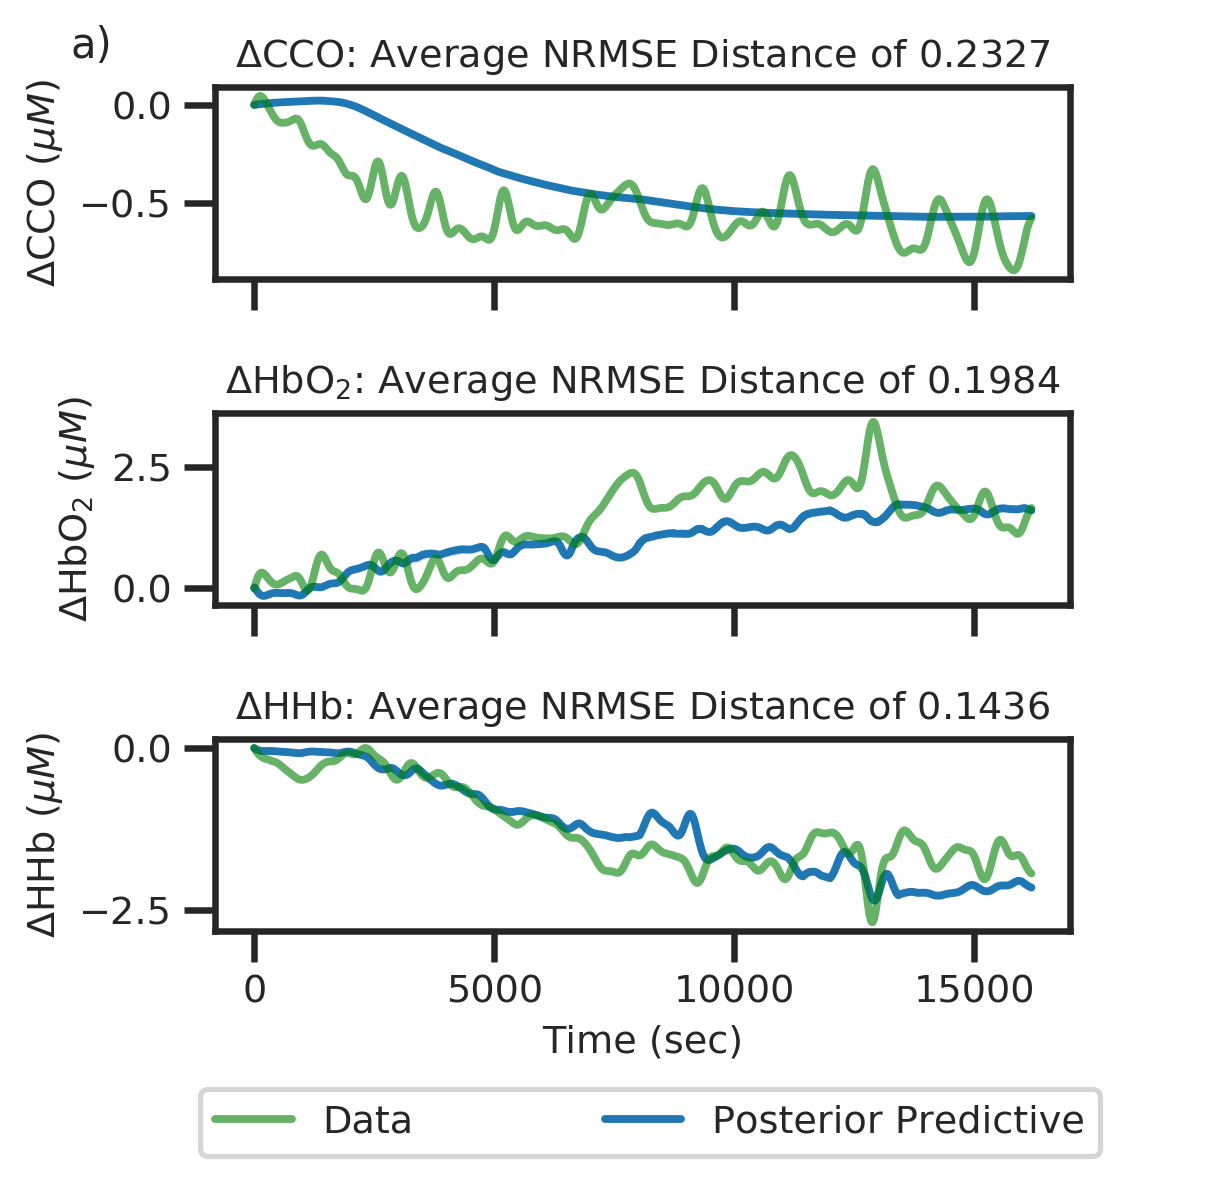

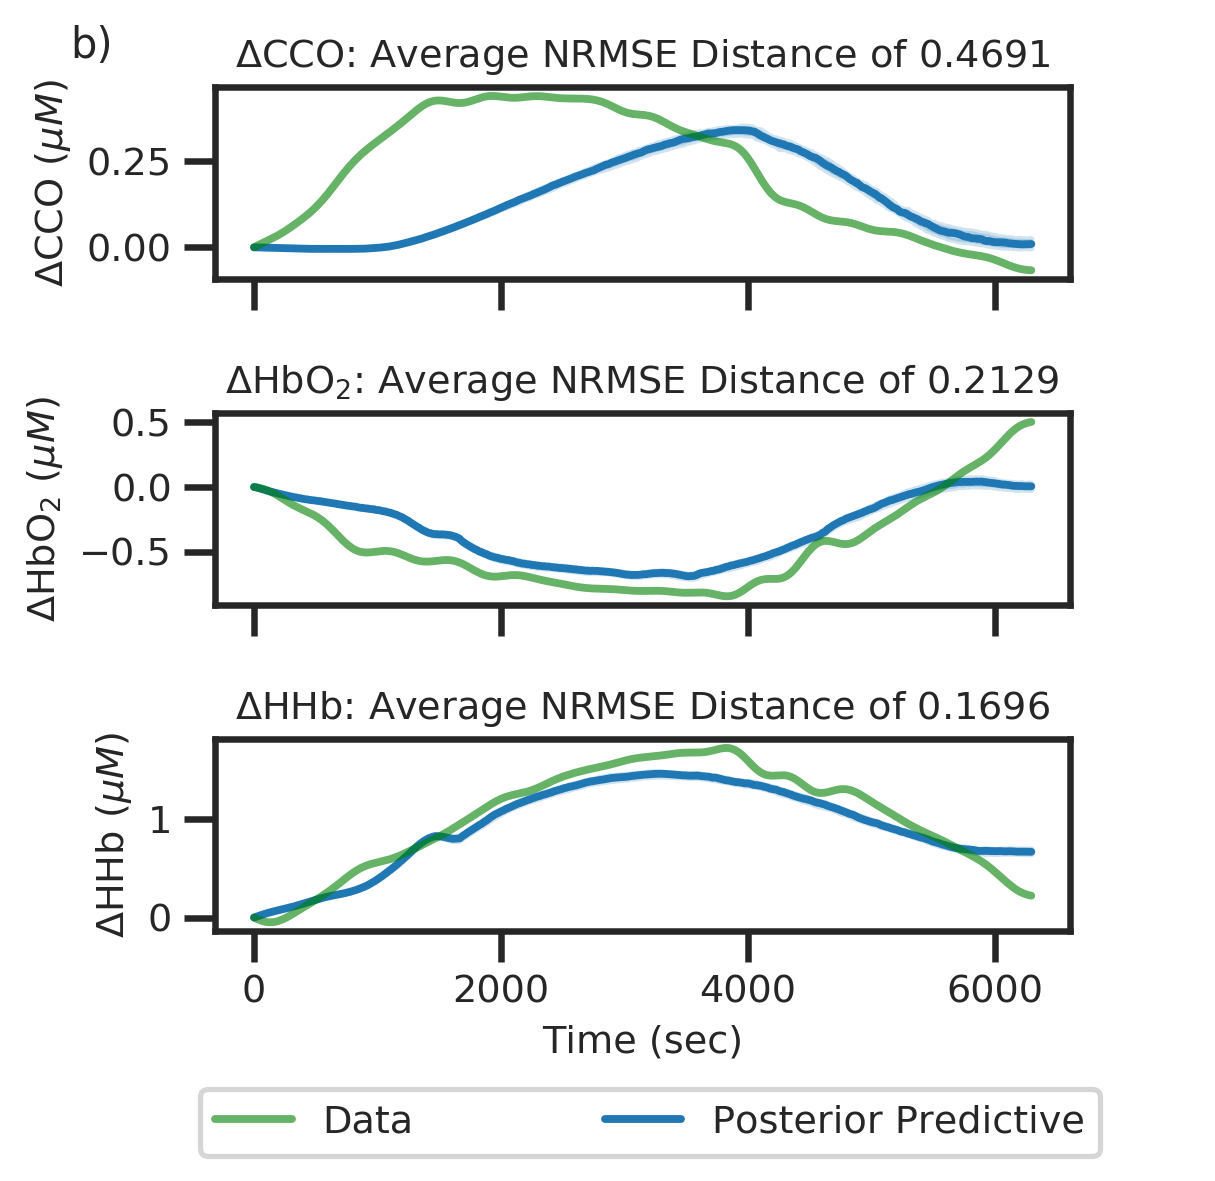

In [8]:
import string
labels = {"t": "Time (sec)",
              "SaO2sup": "SaO2 (%)",
              "P_a": "ABP (mmHg)",
              "temp": "Temperature ($^{\circ}$C)",
               "TOI": "TOI (%)",
              "HbO2": "$\Delta$HbO$_2$ $(\mu M)$",
              "HHb": "$\Delta$HHb $(\mu M)$",
              "CCO": "$\Delta$CCO $(\mu M)$"
             }
LIM=50000
combinations = [('bph2', 'LWP475'), ('bph2_1', 'LWP479')]
signals = ['CCO', 'HbO2', 'HHb']
# for model_name in ['bph2_1']:
#     for DATASET in ['LWP479']:#, 'LWP479' ,'LWP481' ,'LWP484']:
for fig_num, combo in enumerate(combinations):
    DATASET=combo[1]
    model_name=combo[0]
    print("Working on {} - {}".format(model_name, DATASET))
    # Set config and create figure path
    config = configuration[model_name][DATASET]['bayescmd_config']
    figPath = "/home/buck06191/Dropbox/phd/hypothermia/ABC/Figures/{}/{}/{}".format(model_name, DATASET, 'NRMSE')
    dir_util.mkpath(figPath)

    # Get posterior
    print("\tRunning SQL query")
    df_post = client.query(configuration[model_name][DATASET]['posterior_query']).to_dataframe()

    # Plot posterior 
    print("\tPlotting posterior")
#     g = kde_plot(df_post, config['parameters'], limit=LIM, n_ticks=4, d="NRMSE", median_file=os.path.join(figPath, "medians.txt"))
    #g.fig._suptitle.set_text(g.fig._suptitle.get_text() + 'for {} - {}'.format(DATASET, model_name))
#     with open(os.path.join(figPath, 'posterior_{}_{}.pickle'.format(model_name, DATASET)), 'wb') as f: 
#         pickle.dump(g, f)
#     g.fig.savefig(
#         os.path.join(figPath, 'posterior_{}_{}.png'
#                      .format(model_name, DATASET)),
#         bbox_inches='tight', dpi=250)

    # Plot posterior predictive
    config["offset"] = {}
    print("\tPlotting Posterior Predictive")
    fig, axes, lgd = plot_repeated_outputs(df_post, n_repeats=1000, limit=LIM,
                                    distance='NRMSE', **config)
    for ix, ax in enumerate(axes.flatten()):
        ax.set_ylabel(labels[signals[ix]])
        old_title = ax.get_title().split(':')
        new_title = ":".join([labels[signals[ix]].split()[0], old_title[1]])
        ax.set_title(new_title, size=11)
    axes.flatten()[-1].set_xlabel(labels['t'])
    fig.suptitle(string.ascii_lowercase[fig_num]+")", ha='left', x=-0.02, y=0.925)
    #fig.set_size_inches(18.5, 12.5)
    with open(os.path.join(figPath, 'posterior_predictive_{}_{}.pickle'.format(model_name, DATASET)), 'wb') as f: 
        pickle.dump(fig, f)
    fig.savefig(
        os.path.join(figPath, 'posterior_predictive_{}_{}.png'
                     .format(model_name, DATASET)),
        bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=250)
        #plt.close('all')

In [9]:
# fig.subplots_adjust(bottom=0.2)
# for ax in fig.axes:
#     ax.set_ylabel("$\Delta$" + ax.get_ylabel()+" ($\mu$M)")
# with open(os.path.join(figPath, 'posterior_predictive_{}_{}.pickle'.format(model_name, DATASET)), 'wb') as f: 
#             pickle.dump(fig, f)
# fig.savefig(
#     os.path.join(figPath, 'posterior_predictive_{}_{}.png'
#                  .format(model_name, DATASET)),
#     bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=250)

In [10]:
# configuration = {}
# for model_number in [1, 2, 4]:
#     model_name = 'bph{}'.format(model_number)
#     configuration[model_name] = {}
#     for DATASET in ['LWP475', 'LWP479' ,'LWP481' ,'LWP484']: 
#         configuration[model_name][DATASET] = {}
#         for output in ['CCO', 'HbO2', 'HHb']:
#             configuration[model_name][DATASET][output] = {}
#             config, d0 = load_configuration(model_number, DATASET)
#             configuration[model_name][DATASET][output]['bayescmd_config'] = config
#             configuration[model_name][DATASET][output]['original_data']= d0

#             configuration[model_name][DATASET][output]['histogram_query'] = generate_histogram_query('hypothermia-bayescmd', 
#                                                                                                 DATASET, 
#                                                                                                 model_name, 
#                                                                                                 100, 
#                                                                                                 '{}_NRMSE'.format(output))

#             configuration[model_name][DATASET][output]['posterior_query'] = generate_posterior_query('hypothermia-bayescmd', 
#                                                                                                 DATASET, 
#                                                                                                 model_name, 
#                                                                                                 '{}_NRMSE'.format(output), 
#                                                                                                 list(configuration[model_name][DATASET][output]['bayescmd_config']['parameters'].keys()))


In [11]:
# %%capture individual_outputs
# LIM=5000
# for model_name in ['bph1', 'bph2', 'bph4']:
#     for DATASET in ['LWP475', 'LWP479' ,'LWP481' ,'LWP484']:
#         for output in ['CCO', 'HbO2', 'HHb']:
#             print("Working on {} - {}, {}\n".format(model_name, DATASET, output))
#             # Set config and create figure path
#             config = configuration[model_name][DATASET][output]['bayescmd_config']
#             figPath = "/home/buck06191/Dropbox/phd/hypothermia/ABC/Figures/{}/{}/{}".format(model_name, DATASET, '{}_NRMSE'.format(output))
#             dir_util.mkpath(figPath)

#             # Get posterior
#             df_post = client.query(configuration[model_name][DATASET][output]['posterior_query']).to_dataframe()

#             # Plot posterior 
#             g = kde_plot(df_post, config['parameters'], limit=LIM, n_ticks=4, d="{}_NRMSE".format(output), median_file=os.path.join(figPath, "medians.txt"))
#             g.fig._suptitle.set_text(g.fig._suptitle.get_text() + 'for {} - {}, {}'.format(DATASET, model_name,output))
#             g.fig._suptitle.set_fontsize(26)
#             with open(os.path.join(figPath, 'posterior_{}_{}_{}.pickle'.format(model_name, DATASET,output)), 'wb') as f: 
#                 pickle.dump(g, f)
#             g.fig.savefig(
#                 os.path.join(figPath, 'posterior_{}_{}_{}.png'
#                              .format(model_name, DATASET,output)),
#                 bbox_inches='tight', dpi=250)

#             # Plot posterior predictive
#             config["offset"] = {}
#             fig, ax, lgd = plot_repeated_outputs(df_post, n_repeats=100, limit=LIM,
#                                             distance='{}_NRMSE'.format(output), **config)
#             fig.suptitle('Posterior predictive distributions\nfor {} - {}, {}'.format(DATASET, model_name,output), fontsize=26)
#             fig.set_size_inches(18.5, 12.5)
#             with open(os.path.join(figPath, 'posterior_predictive_{}_{}_{}.pickle'.format(model_name, DATASET, output)), 'wb') as f: 
#                 pickle.dump(fig, f)
#             fig.savefig(
#                 os.path.join(figPath, 'posterior_predictive_{}_{}_{}.png'
#                              .format(model_name, DATASET,output)),
#                 bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=250)
#             plt.close('all')

In [12]:
string.ascii_lowercase[0]

'a'